# Baseline Model

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [428]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/PCB_df.csv' #use this command if using Google Colab
PCB_df = pd.read_csv(file_path, low_memory=False, index_col=0)

#PCB_df = pd.read_csv(PCB_df.csv, low_memory=False, index_col=0) #use this command if running in Jupyter Notebook



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [429]:
PCB_df.drop_duplicates(inplace=True) #Dropping the duplicates since models does not do well with these



## First Model - Linear Regression with PCB_Result/Organism as target variable

The first model that I am going to try is a simple linear regression looking at the PCB Results per OrganismID levels since it is numerical.

Sidenote for the teachers: I had over 5 different iterations of this model, at first using the 20% dataset. Then later dropping different columns to tune the VIF values, but all work has been lost when my laptop crashed and I had to switch over to Google Colab to run the models, so now I only have these



In [430]:
X = PCB_df.drop('PCB_Result/Organism', axis=1)
y = PCB_df['PCB_Result/Organism'].copy()

In [431]:
X.columns

Index(['OrganismID_Number', 'Latitude', 'Longitude', 'WeightAvg(g)',
       'TLMax(mm)', 'TLAvgLength(mm)', 'CompositeLatitude',
       'CompositeLongitude', 'TotalLength(mm)', 'OrganismWeight(g)',
       'TissueWeight(g)', 'CompositeWeight(g)', 'TLMin(mm)',
       'PCBResult(ng/g ww)', 'PCB_threshold', 'EarliestDateSampledMonth',
       'EarliestDateSampledYear', 'EarliestDateSampledDay',
       'SpeciesGroup_Freshwater Piscivores',
       'SpeciesGroup_Freshwater Top Predators',
       'SpeciesGroup_Saltwater Omnivores', 'SpeciesGroup_Saltwater Piscivores',
       'SpeciesGroup_Saltwater Piscivores Forage',
       'SpeciesGroup_Saltwater Primary Consumer Forage',
       'SpeciesGroup_Saltwater Top Predators', 'CommonName_Black Perch',
       'CommonName_Blue Catfish', 'CommonName_Bluegill',
       'CommonName_Brown Rockfish', 'CommonName_California Corbina',
       'CommonName_Channel Catfish', 'CommonName_Chinook Salmon',
       'CommonName_Chub Mackerel', 'CommonName_Common Carp',


In [432]:
y

0        15.88
10       15.88
20       15.88
24       15.88
34       15.88
         ...  
77598     0.00
77599     0.00
77600     0.00
77601     0.00
77602     0.00
Name: PCB_Result/Organism, Length: 41278, dtype: float64

### Detecting Collinearity

Finding the pairwise correlation between the independent variables using .corr and heatlamp map

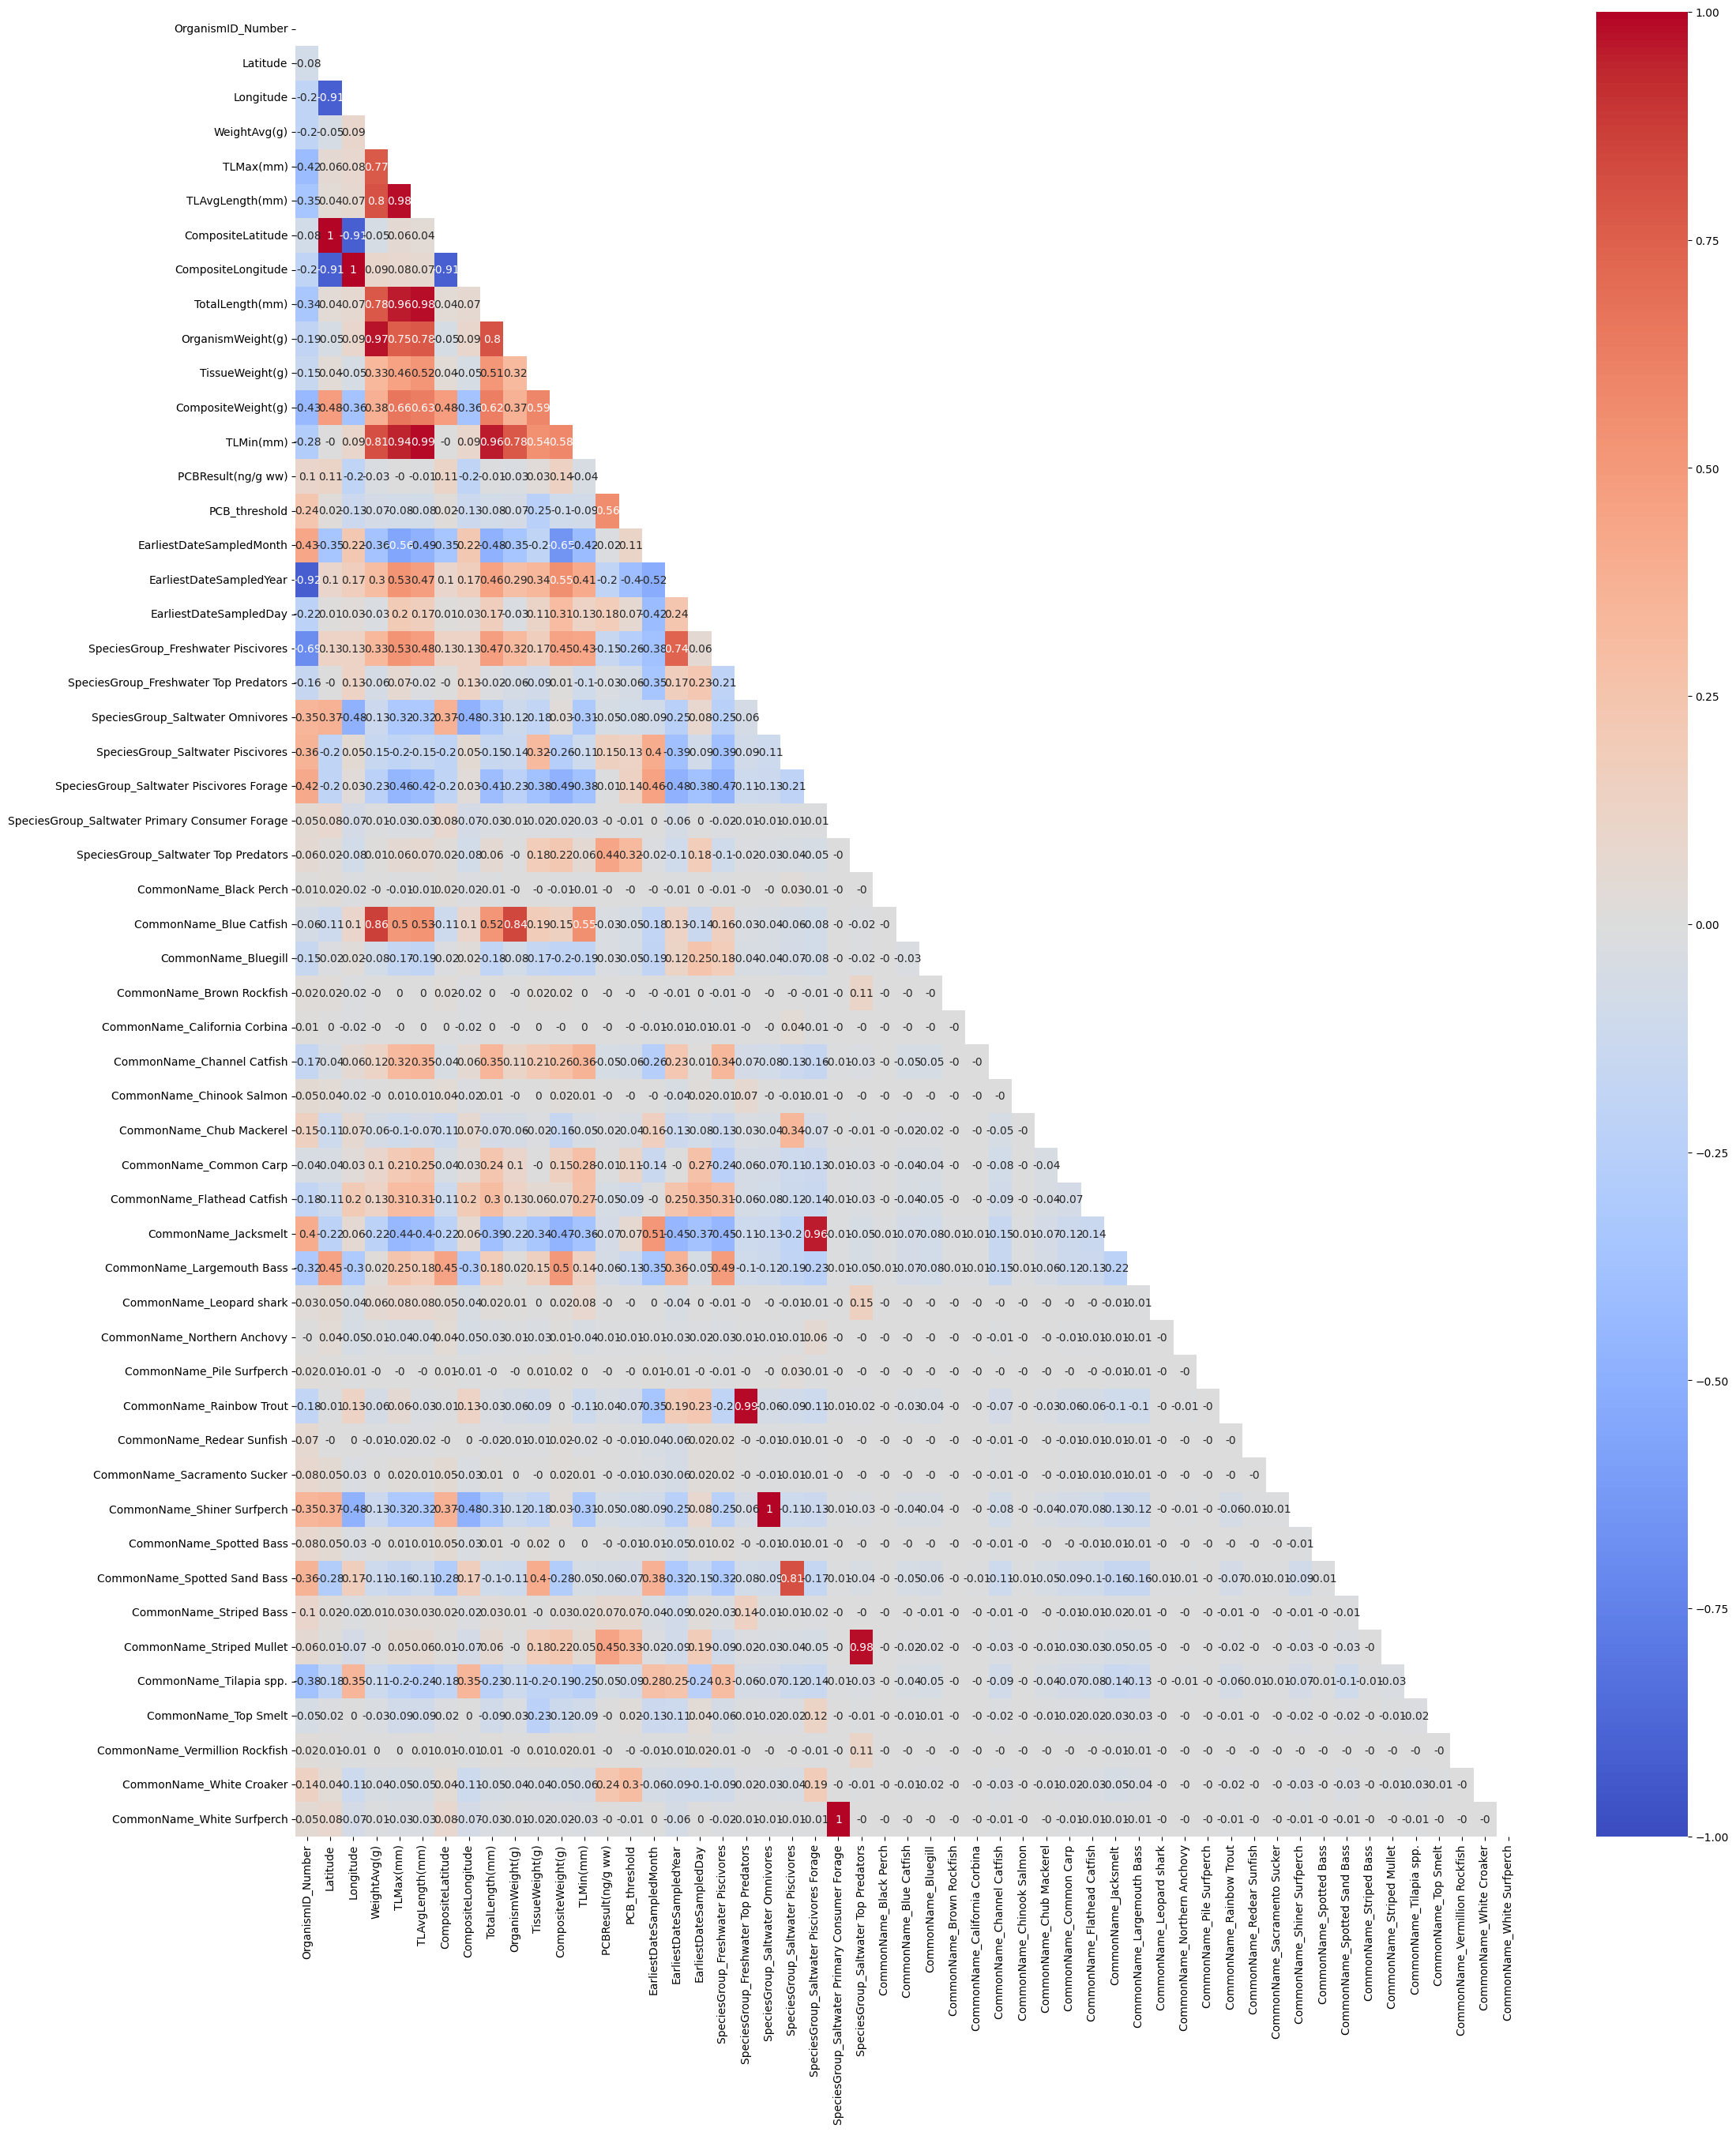

In [433]:
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(25,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

In [434]:
X_drop_col = ['Longitude', 'TLMax(mm)', 'TLAvgLength(mm)',
       'CompositeLatitude','CompositeLongitude','TotalLength(mm)',
       'OrganismWeight(g)',
       'TLMin(mm)', 'PCBResult(ng/g ww)',
       'OrganismID_Number', 'EarliestDateSampledYear'
       ]
X.drop(columns=X_drop_col, inplace=True)
#These are columns that has correlation varible above 0.7

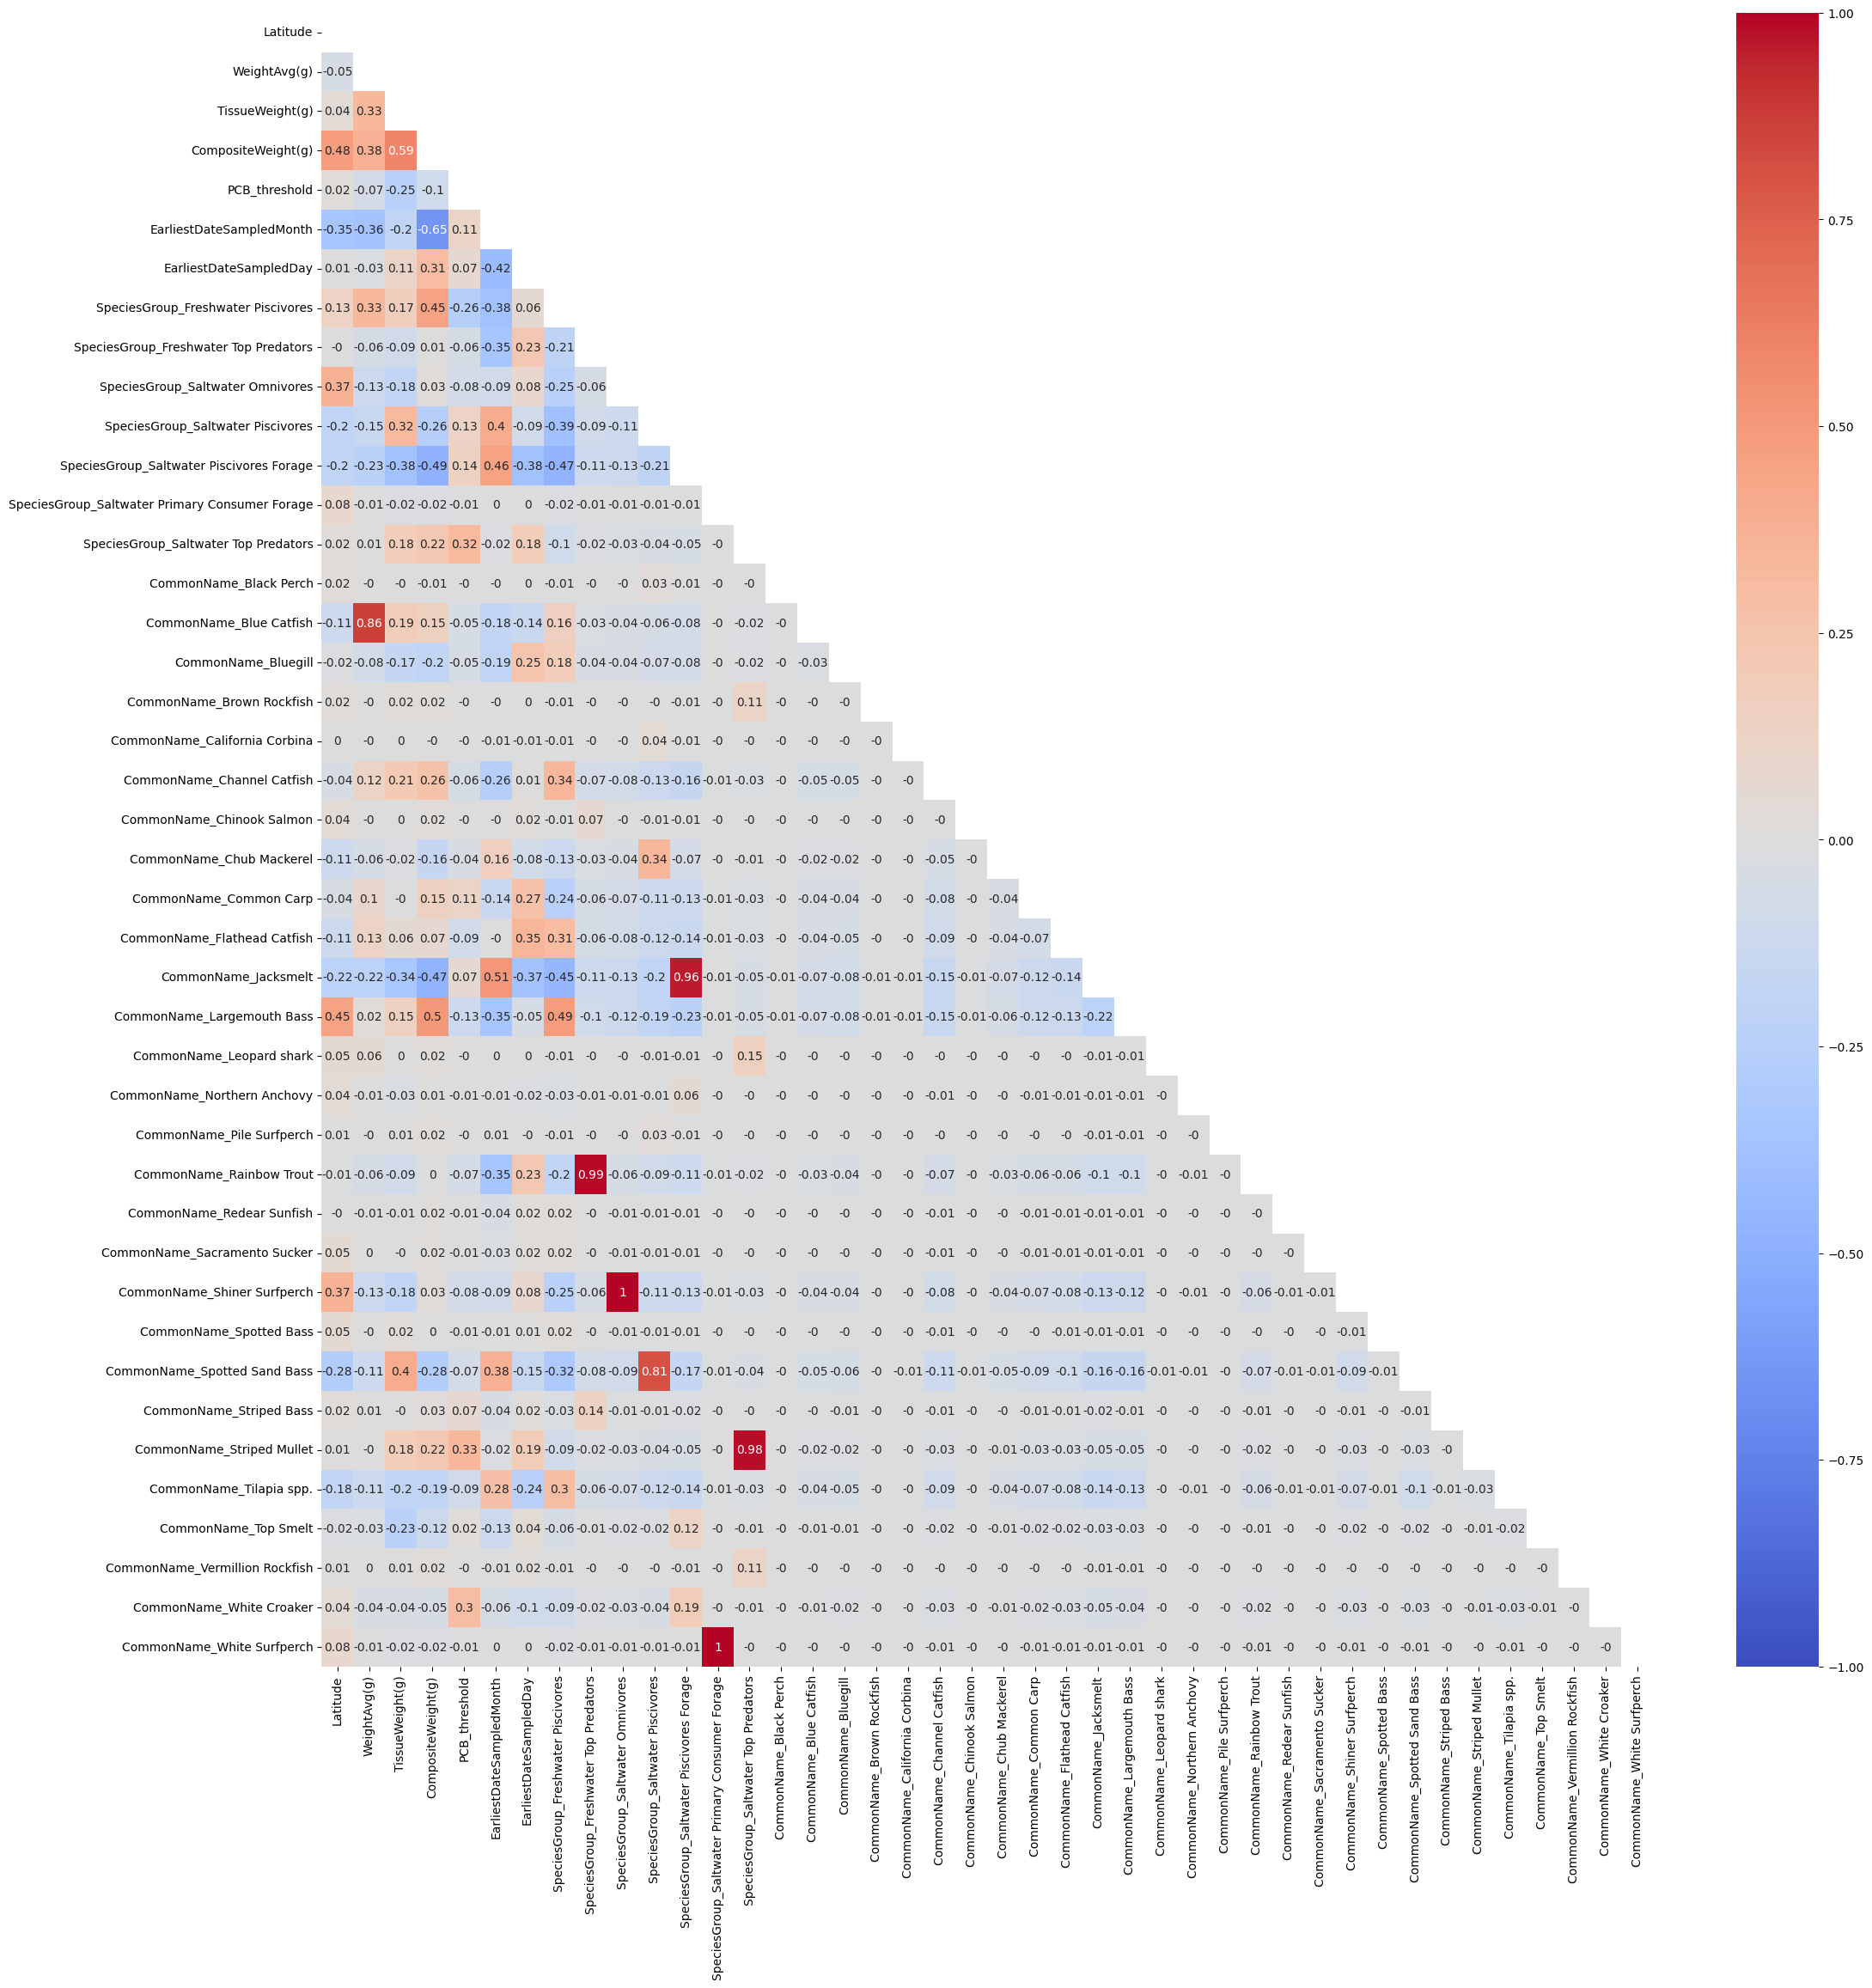

In [435]:
#Reiterate
corr_df = X.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(25,25))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

In [436]:
# I decided to drop all the SpeciesGroup columns since I had done a model dropping the common name instead but the performances for both linear and logisitc regressions were very poor
# These columns show a very strong correlation with some of the common names.
columns_with_speciesgroup = [col for col in X.columns if 'SpeciesGroup' in col]
columns_with_speciesgroup

['SpeciesGroup_Freshwater Piscivores',
 'SpeciesGroup_Freshwater Top Predators',
 'SpeciesGroup_Saltwater Omnivores',
 'SpeciesGroup_Saltwater Piscivores',
 'SpeciesGroup_Saltwater Piscivores Forage',
 'SpeciesGroup_Saltwater Primary Consumer Forage',
 'SpeciesGroup_Saltwater Top Predators']

In [437]:
X.drop(columns=columns_with_speciesgroup, inplace=True)

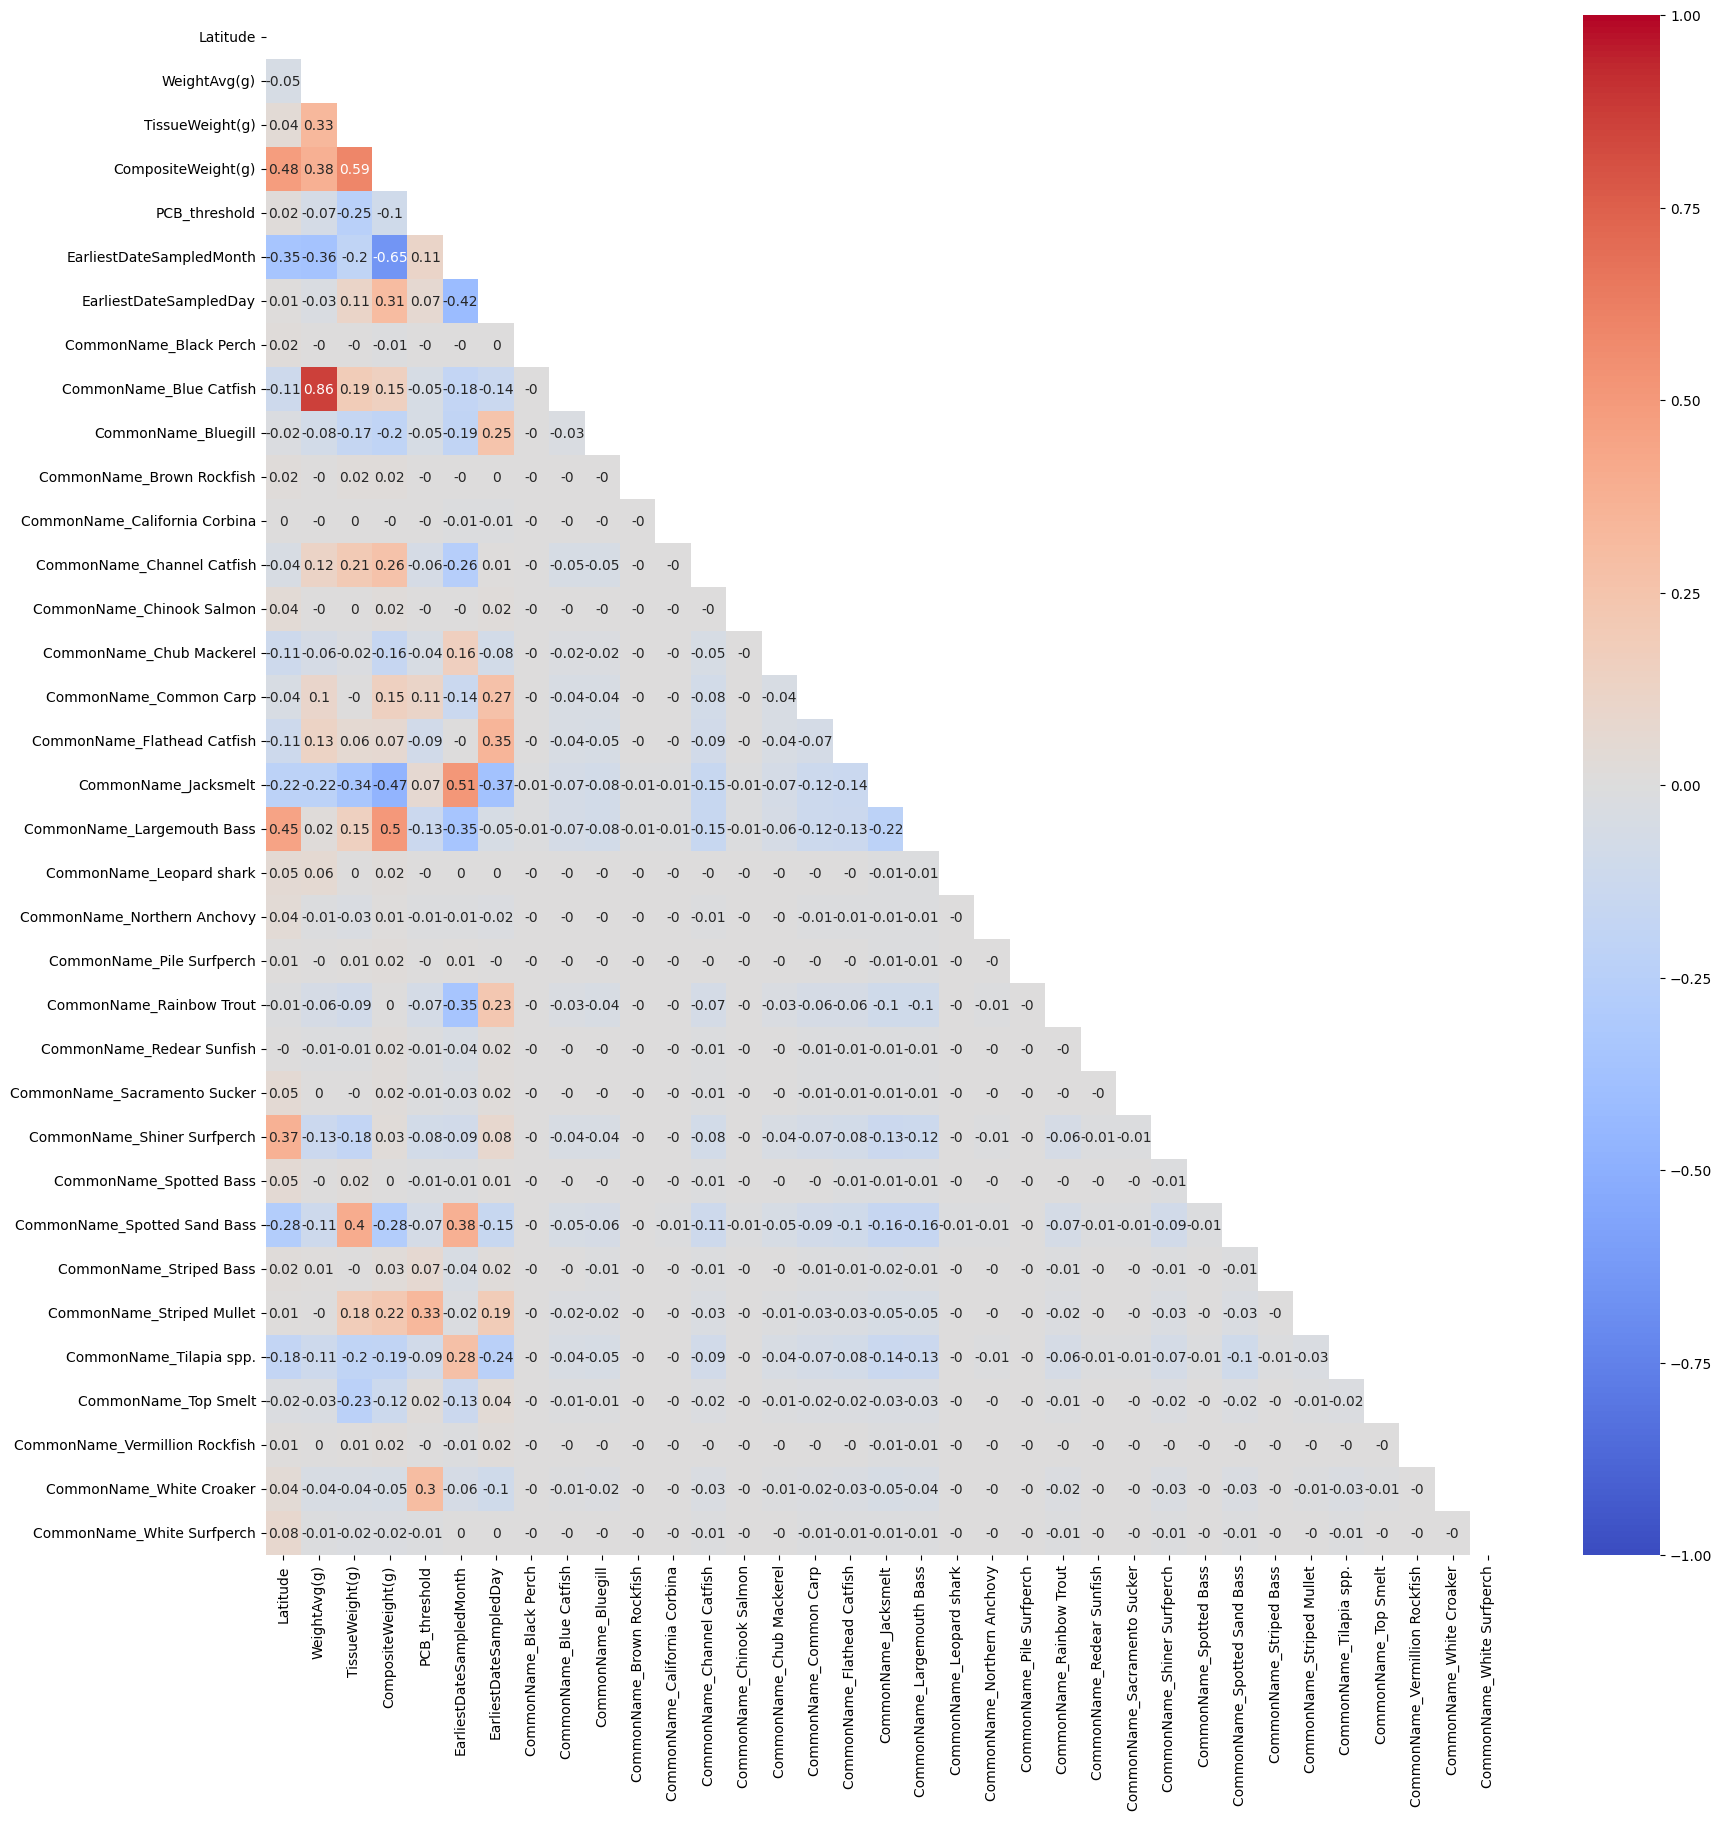

In [438]:
# 2 reiteration
corr_df = X.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

#Leaving the catfish for now...

### Detect Multicollinearity Between X Variables

By using the Variance Inflation Factor(VIF) to detect multicollinearity. The value would be 1 if there is no multicollinearity. If the value is higher than 5, then there is very strong multicollinearity.

In [439]:
X1 = X.copy() # making a copy of the dataframe so X could be reused for other models

In [440]:
X_withconstant = sm.add_constant(X1) #adding constant
X_withconstant.shape[1] #check shape

36

In [441]:
variance_inflation_factor(X_withconstant, 1)

2.8418215408140504

In [442]:
pd.Series([variance_inflation_factor(X_withconstant.values, i)
          for i in range(X_withconstant.shape[1])],
         index=X_withconstant.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.841822
WeightAvg(g)                       8.192829
TissueWeight(g)                    6.668672
CompositeWeight(g)                11.454654
PCB_threshold                      2.462116
EarliestDateSampledMonth           7.904207
EarliestDateSampledDay             3.118463
CommonName_Black Perch             1.009792
CommonName_Blue Catfish            8.542236
CommonName_Bluegill                3.769381
CommonName_Brown Rockfish          1.007366
CommonName_California Corbina      1.017610
CommonName_Channel Catfish         6.889453
CommonName_Chinook Salmon          1.017483
CommonName_Chub Mackerel           3.312349
CommonName_Common Carp             4.441593
CommonName_Flathead Catfish        6.186452
CommonName_Jacksmelt              15.742902
CommonName_Largemouth Bass        10.378617
CommonName_Leopard shark           1.049475
CommonName_Northern Anchovy        1.066070
CommonName_Pile Surfperch          1.009457
CommonName_Rainbow Trout           4.843150
CommonName_Redear Sunfish          1.043727
CommonName_Sacramento Sucker       1.038022
CommonName_Shiner Surfperch        5.251248
CommonName_Spotted Bass            1.030423
CommonName_Spotted Sand Bass      14.158962
CommonName_Striped Bass            1.054311
CommonName_Striped Mullet          1.621602
CommonName_Tilapia spp.            7.964516
CommonName_Top Smelt               1.667079
CommonName_Vermillion Rockfish     1.007416
CommonName_White Croaker           1.614433
CommonName_White Surfperch         1.063785
dtype: float64

In [443]:
#Weight has the highest value of 10, I drop that first and see how that affects all the other values
X1.drop(columns=['WeightAvg(g)'], inplace=True)

In [444]:
X_withconstant = sm.add_constant(X1)
variance_inflation_factor(X_withconstant, 1)
pd.Series([variance_inflation_factor(X_withconstant.values, i)
          for i in range(X_withconstant.shape[1])],
         index=X_withconstant.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.841070
TissueWeight(g)                    6.668410
CompositeWeight(g)                11.363122
PCB_threshold                      2.452797
EarliestDateSampledMonth           7.492642
EarliestDateSampledDay             2.996663
CommonName_Black Perch             1.009790
CommonName_Blue Catfish            3.080755
CommonName_Bluegill                3.768422
CommonName_Brown Rockfish          1.007358
CommonName_California Corbina      1.017610
CommonName_Channel Catfish         6.763014
CommonName_Chinook Salmon          1.017336
CommonName_Chub Mackerel           3.306882
CommonName_Common Carp             4.232721
CommonName_Flathead Catfish        5.695370
CommonName_Jacksmelt              15.728464
CommonName_Largemouth Bass        10.369523
CommonName_Leopard shark           1.017884
CommonName_Northern Anchovy        1.065464
CommonName_Pile Surfperch          1.009449
CommonName_Rainbow Trout           4.833810
CommonName_Redear Sunfish          1.042981
CommonName_Sacramento Sucker       1.037913
CommonName_Shiner Surfperch        5.237017
CommonName_Spotted Bass            1.030339
CommonName_Spotted Sand Bass      14.101991
CommonName_Striped Bass            1.054142
CommonName_Striped Mullet          1.620582
CommonName_Tilapia spp.            7.953507
CommonName_Top Smelt               1.664018
CommonName_Vermillion Rockfish     1.007142
CommonName_White Croaker           1.602548
CommonName_White Surfperch         1.063755
dtype: float64

In [445]:
# CompositeWeight has a value of 9.211074
X1.drop(columns=['CompositeWeight(g)'], inplace=True)

In [446]:
X_withconstant = sm.add_constant(X1)
variance_inflation_factor(X_withconstant, 1)
pd.Series([variance_inflation_factor(X_withconstant.values, i)
          for i in range(X_withconstant.shape[1])],
         index=X_withconstant.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.685327
TissueWeight(g)                    3.550663
PCB_threshold                      2.444900
EarliestDateSampledMonth           7.368586
EarliestDateSampledDay             2.979705
CommonName_Black Perch             1.007979
CommonName_Blue Catfish            3.065222
CommonName_Bluegill                3.189178
CommonName_Brown Rockfish          1.007270
CommonName_California Corbina      1.016203
CommonName_Channel Catfish         6.742269
CommonName_Chinook Salmon          1.016703
CommonName_Chub Mackerel           2.882427
CommonName_Common Carp             4.230848
CommonName_Flathead Catfish        5.542693
CommonName_Jacksmelt              14.132201
CommonName_Largemouth Bass        10.324691
CommonName_Leopard shark           1.016857
CommonName_Northern Anchovy        1.065448
CommonName_Pile Surfperch          1.009274
CommonName_Rainbow Trout           4.693678
CommonName_Redear Sunfish          1.042967
CommonName_Sacramento Sucker       1.037909
CommonName_Shiner Surfperch        5.166086
CommonName_Spotted Bass            1.022649
CommonName_Spotted Sand Bass      10.794547
CommonName_Striped Bass            1.051860
CommonName_Striped Mullet          1.566807
CommonName_Tilapia spp.            7.613161
CommonName_Top Smelt               1.637048
CommonName_Vermillion Rockfish     1.007111
CommonName_White Croaker           1.522759
CommonName_White Surfperch         1.050679
dtype: float64

In [447]:
#  Spotted Sand Bass VIF = 10.794547
X1.drop(columns=['CommonName_Spotted Sand Bass'], inplace=True)
X_withconstant = sm.add_constant(X1)
variance_inflation_factor(X_withconstant, 1)
pd.Series([variance_inflation_factor(X_withconstant.values, i)
          for i in range(X_withconstant.shape[1])],
         index=X_withconstant.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                          2.010466
TissueWeight(g)                   3.199734
PCB_threshold                     2.179193
EarliestDateSampledMonth          5.950264
EarliestDateSampledDay            2.429502
CommonName_Black Perch            1.005170
CommonName_Blue Catfish           1.787717
CommonName_Bluegill               2.807986
CommonName_Brown Rockfish         1.002765
CommonName_California Corbina     1.005848
CommonName_Channel Catfish        3.355698
CommonName_Chinook Salmon         1.013820
CommonName_Chub Mackerel          1.246542
CommonName_Common Carp            2.682284
CommonName_Flathead Catfish       2.651243
CommonName_Jacksmelt              3.350669
CommonName_Largemouth Bass        6.092255
CommonName_Leopard shark          1.012357
CommonName_Northern Anchovy       1.039196
CommonName_Pile Surfperch         1.001191
CommonName_Rainbow Trout          4.002196
CommonName_Redear Sunfish         1.035788
CommonName_Sacramento Sucker      1.034075
CommonName_Shiner Surfperch       3.811952
CommonName_Spotted Bass           1.016787
CommonName_Striped Bass           1.041594
CommonName_Striped Mullet         1.372469
CommonName_Tilapia spp.           2.271656
CommonName_Top Smelt              1.631087
CommonName_Vermillion Rockfish    1.003759
CommonName_White Croaker          1.336690
CommonName_White Surfperch        1.039451
dtype: float64

### Fitting the Linear Model

Fitting the model with backward selection now that all VIF values are under the value = 5 threshold


In [448]:

# 0. ADD THAT CONSTANT
X_const = sm.add_constant(X1)

# 1. Instatiate the model
PCB_Lin= sm.OLS(y, X_const)

# Fit the model
PCB_Lin_fitted = PCB_Lin.fit()


# Look at the results
PCB_Lin_fitted.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     PCB_Result/Organism   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.813
Method:                  Least Squares   F-statistic:                     5615.
Date:                 Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                         04:35:59   Log-Likelihood:            -3.1560e+05
No. Observations:                41278   AIC:                         6.313e+05
Df Residuals:                    41245   BIC:                         6.315e+05
Df Model:                           32                                         
Covariance Type:             nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -4554.9413     70.391    -64.709      0.000   -4692.909   -4416.974
Latitude                         200.5896      1.793    111.861      0.000     197.075     204.104
TissueWeight(g)                   -8.4888      0.143    -59.549      0.000      -8.768      -8.209
PCB_threshold                   1308.4162     13.183     99.247      0.000    1282.576    1334.256
EarliestDateSampledMonth        -162.2995      2.758    -58.855      0.000    -167.704    -156.895
EarliestDateSampledDay            54.1766      0.470    115.356      0.000      53.256      55.097
CommonName_Black Perch         -2476.4033    227.022    -10.908      0.000   -2921.371   -2031.435
CommonName_Blue Catfish         -856.6865     22.335    -38.355      0.000    -900.464    -812.909
CommonName_Bluegill            -2837.1288     26.149   -108.499      0.000   -2888.381   -2785.876
CommonName_Brown Rockfish      -1885.3268    226.750     -8.315      0.000   -2329.762   -1440.891
CommonName_California Corbina  -1358.0665    169.277     -8.023      0.000   -1689.854   -1026.279
CommonName_Channel Catfish     -1591.9253     15.753   -101.058      0.000   -1622.801   -1561.050
CommonName_Chinook Salmon      -3242.7853    161.228    -20.113      0.000   -3558.795   -2926.775
CommonName_Chub Mackerel        -561.0167     20.047    -27.984      0.000    -600.310    -521.723
CommonName_Common Carp         -2185.6654     17.050   -128.193      0.000   -2219.083   -2152.247
CommonName_Flathead Catfish    -1847.2957     15.328   -120.518      0.000   -1877.339   -1817.253
CommonName_Jacksmelt            -928.0976     11.723    -79.169      0.000    -951.075    -905.120
CommonName_Largemouth Bass     -2043.4279     16.245   -125.792      0.000   -2075.268   -2011.588
CommonName_Leopard shark       -2828.4688    161.111    -17.556      0.000   -3144.251   -2512.687
CommonName_Northern Anchovy    -2055.7853     86.059    -23.888      0.000   -2224.462   -1887.109
CommonName_Pile Surfperch      -1048.0472    226.572     -4.626      0.000   -1492.134    -603.961
CommonName_Rainbow Trout       -2653.2825     23.899   -111.021      0.000   -2700.125   -2606.440
CommonName_Redear Sunfish      -2680.6095    115.248    -23.260      0.000   -2906.498   -2454.721
CommonName_Sacramento Sucker   -3321.6142    115.152    -28.845      0.000   -3547.316   -3095.913
CommonName_Shiner Surfperch    -2498.7767     19.712   -126.762      0.000   -2537.413   -2460.140
CommonName_Spotted Bass        -2839.1309    131.842    -21.534      0.000   -3097.545   -2580.717
CommonName_Striped Bass        -3255.6564     80.738    -40.324      0.000   -3413.905   -3097.407
CommonName_Striped Mullet       3920.5091     29.091    134.768      0.000    3863.491    3977.528
Com

### Model Evaluation

The R^2 Value for this model is 0.813. This value is a measure of how much of the total variance in our dependent variable was explained by our model. It is between 0 & 1. The closer to 1, the better fitted this model is. This means are model prediction power is decent.

The p-values are also all under 0.05, we can throw out the null hypothesis, meaning that there is a correlation between these X-variables and the target y variable

### Looking at Coefficients

Next I look at the coefficients to see which variables has the highest. Mullet shows the most positive correlation while Top Smelt shows the most negative correlation

<Axes: >

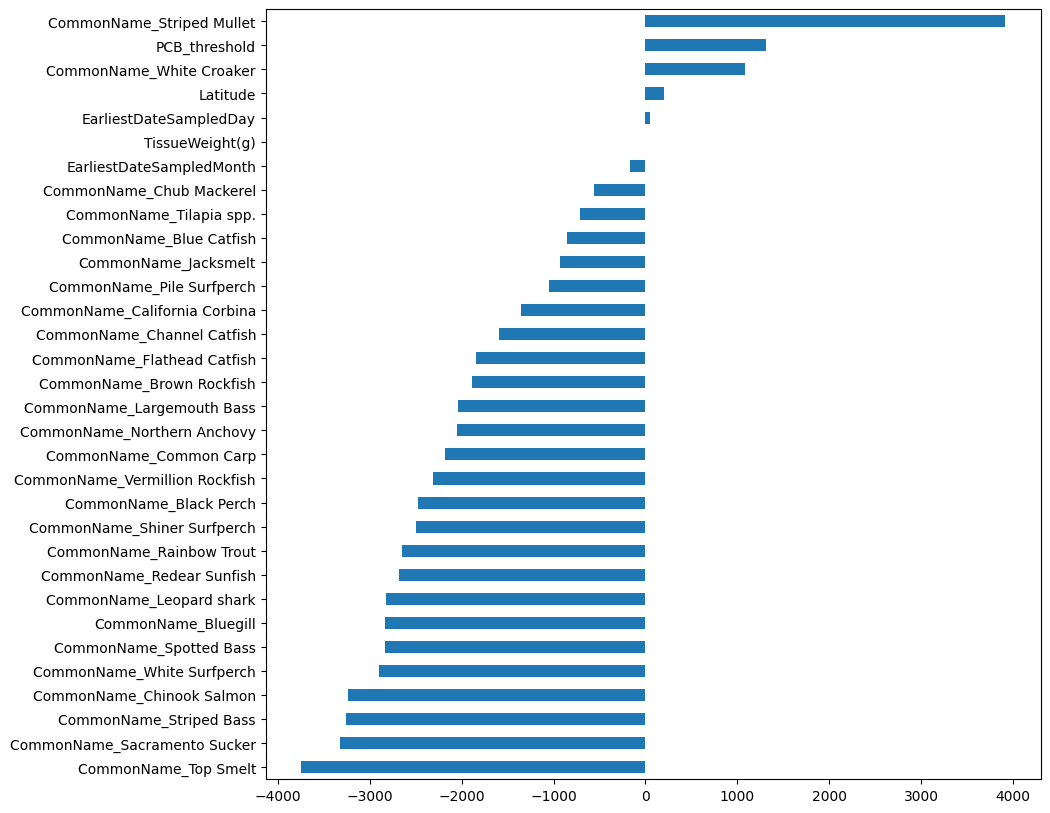

In [449]:
params_series = PCB_Lin_fitted.params
p_values_series = PCB_Lin_fitted.pvalues

significant_params = params_series[p_values_series < 0.05]
significant_params.drop('const', inplace=True)

plt.figure(figsize=(10, 10))
significant_params.sort_values().plot(kind='barh')

## Linear Model #2

I want to repeat the same process but drop different VIF values and in different orders to see how that would affect my model performance

#### Delecting Multicolinearity with VIF

In [450]:
X2 = X.copy()

In [451]:
X_withconstant2 = sm.add_constant(X2)
variance_inflation_factor(X_withconstant2, 1)
pd.Series([variance_inflation_factor(X_withconstant2.values, i)
          for i in range(X_withconstant2.shape[1])],
         index=X_withconstant2.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.841822
WeightAvg(g)                       8.192829
TissueWeight(g)                    6.668672
CompositeWeight(g)                11.454654
PCB_threshold                      2.462116
EarliestDateSampledMonth           7.904207
EarliestDateSampledDay             3.118463
CommonName_Black Perch             1.009792
CommonName_Blue Catfish            8.542236
CommonName_Bluegill                3.769381
CommonName_Brown Rockfish          1.007366
CommonName_California Corbina      1.017610
CommonName_Channel Catfish         6.889453
CommonName_Chinook Salmon          1.017483
CommonName_Chub Mackerel           3.312349
CommonName_Common Carp             4.441593
CommonName_Flathead Catfish        6.186452
CommonName_Jacksmelt              15.742902
CommonName_Largemouth Bass        10.378617
CommonName_Leopard shark           1.049475
CommonName_Northern Anchovy        1.066070
CommonName_Pile Surfperch          1.009457
CommonName_Rainbow Trout           4.843150
CommonName_Redear Sunfish          1.043727
CommonName_Sacramento Sucker       1.038022
CommonName_Shiner Surfperch        5.251248
CommonName_Spotted Bass            1.030423
CommonName_Spotted Sand Bass      14.158962
CommonName_Striped Bass            1.054311
CommonName_Striped Mullet          1.621602
CommonName_Tilapia spp.            7.964516
CommonName_Top Smelt               1.667079
CommonName_Vermillion Rockfish     1.007416
CommonName_White Croaker           1.614433
CommonName_White Surfperch         1.063785
dtype: float64

In [452]:
# This time I chose to drop CompositeWeight first

X2.drop(columns=['CompositeWeight(g)'], inplace=True)
X_withconstant2 = sm.add_constant(X2)
variance_inflation_factor(X_withconstant2, 1)
pd.Series([variance_inflation_factor(X_withconstant2.values, i)
          for i in range(X_withconstant2.shape[1])],
         index=X_withconstant2.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.685390
WeightAvg(g)                       8.127361
TissueWeight(g)                    3.580925
PCB_threshold                      2.452681
EarliestDateSampledMonth           7.818089
EarliestDateSampledDay             3.092575
CommonName_Black Perch             1.008004
CommonName_Blue Catfish            8.431323
CommonName_Bluegill                3.198955
CommonName_Brown Rockfish          1.007284
CommonName_California Corbina      1.016219
CommonName_Channel Catfish         6.858744
CommonName_Chinook Salmon          1.016908
CommonName_Chub Mackerel           2.882664
CommonName_Common Carp             4.434544
CommonName_Flathead Catfish        5.982312
CommonName_Jacksmelt              14.132247
CommonName_Largemouth Bass        10.337666
CommonName_Leopard shark           1.049218
CommonName_Northern Anchovy        1.066067
CommonName_Pile Surfperch          1.009289
CommonName_Rainbow Trout           4.710506
CommonName_Redear Sunfish          1.043689
CommonName_Sacramento Sucker       1.038013
CommonName_Shiner Surfperch        5.186427
CommonName_Spotted Bass            1.022650
CommonName_Spotted Sand Bass      10.800197
CommonName_Striped Bass            1.052156
CommonName_Striped Mullet          1.569567
CommonName_Tilapia spp.            7.615903
CommonName_Top Smelt               1.641918
CommonName_Vermillion Rockfish     1.007400
CommonName_White Croaker           1.540670
CommonName_White Surfperch         1.050701
dtype: float64

In [453]:
# Then WeightAvg next

X2.drop(columns=['WeightAvg(g)'], inplace=True)
X_withconstant2 = sm.add_constant(X2)
variance_inflation_factor(X_withconstant2, 1)
pd.Series([variance_inflation_factor(X_withconstant2.values, i)
          for i in range(X_withconstant2.shape[1])],
         index=X_withconstant2.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.685327
TissueWeight(g)                    3.550663
PCB_threshold                      2.444900
EarliestDateSampledMonth           7.368586
EarliestDateSampledDay             2.979705
CommonName_Black Perch             1.007979
CommonName_Blue Catfish            3.065222
CommonName_Bluegill                3.189178
CommonName_Brown Rockfish          1.007270
CommonName_California Corbina      1.016203
CommonName_Channel Catfish         6.742269
CommonName_Chinook Salmon          1.016703
CommonName_Chub Mackerel           2.882427
CommonName_Common Carp             4.230848
CommonName_Flathead Catfish        5.542693
CommonName_Jacksmelt              14.132201
CommonName_Largemouth Bass        10.324691
CommonName_Leopard shark           1.016857
CommonName_Northern Anchovy        1.065448
CommonName_Pile Surfperch          1.009274
CommonName_Rainbow Trout           4.693678
CommonName_Redear Sunfish          1.042967
CommonName_Sacramento Sucker       1.037909
CommonName_Shiner Surfperch        5.166086
CommonName_Spotted Bass            1.022649
CommonName_Spotted Sand Bass      10.794547
CommonName_Striped Bass            1.051860
CommonName_Striped Mullet          1.566807
CommonName_Tilapia spp.            7.613161
CommonName_Top Smelt               1.637048
CommonName_Vermillion Rockfish     1.007111
CommonName_White Croaker           1.522759
CommonName_White Surfperch         1.050679
dtype: float64

In [454]:
# I chose the PCB_threshold to drop even though it has a low VIF value because it was meant to be a binary representation of the current target variable, but made for the logistics model

X2.drop(columns=['PCB_threshold'], inplace=True)
X_withconstant2 = sm.add_constant(X2)
variance_inflation_factor(X_withconstant2, 1)
pd.Series([variance_inflation_factor(X_withconstant2.values, i)
          for i in range(X_withconstant2.shape[1])],
         index=X_withconstant2.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.683876
TissueWeight(g)                    2.953691
EarliestDateSampledMonth           7.360665
EarliestDateSampledDay             2.974822
CommonName_Black Perch             1.004957
CommonName_Blue Catfish            2.806700
CommonName_Bluegill                2.449584
CommonName_Brown Rockfish          1.005764
CommonName_California Corbina      1.012032
CommonName_Channel Catfish         5.509706
CommonName_Chinook Salmon          1.011296
CommonName_Chub Mackerel           2.448982
CommonName_Common Carp             3.539687
CommonName_Flathead Catfish        4.130208
CommonName_Jacksmelt              11.122405
CommonName_Largemouth Bass         7.696599
CommonName_Leopard shark           1.011578
CommonName_Northern Anchovy        1.041251
CommonName_Pile Surfperch          1.007641
CommonName_Rainbow Trout           3.676913
CommonName_Redear Sunfish          1.032301
CommonName_Sacramento Sucker       1.026792
CommonName_Shiner Surfperch        3.545084
CommonName_Spotted Bass            1.017449
CommonName_Spotted Sand Bass       9.621414
CommonName_Striped Bass            1.051581
CommonName_Striped Mullet          1.515463
CommonName_Tilapia spp.            5.799406
CommonName_Top Smelt               1.498572
CommonName_Vermillion Rockfish     1.005484
CommonName_White Croaker           1.520393
CommonName_White Surfperch         1.032012
dtype: float64

In [455]:
# CommonName_Jacksmelt is standing out now...11.122405

X2.drop(columns=['CommonName_Jacksmelt'], inplace=True)
X_withconstant2 = sm.add_constant(X2)
variance_inflation_factor(X_withconstant2, 1)
pd.Series([variance_inflation_factor(X_withconstant2.values, i)
          for i in range(X_withconstant2.shape[1])],
         index=X_withconstant2.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                          2.083311
TissueWeight(g)                   2.801251
EarliestDateSampledMonth          6.494927
EarliestDateSampledDay            2.280969
CommonName_Black Perch            1.002639
CommonName_Blue Catfish           1.708490
CommonName_Bluegill               2.122454
CommonName_Brown Rockfish         1.002383
CommonName_California Corbina     1.003095
CommonName_Channel Catfish        2.657271
CommonName_Chinook Salmon         1.009318
CommonName_Chub Mackerel          1.111657
CommonName_Common Carp            2.125192
CommonName_Flathead Catfish       1.927608
CommonName_Largemouth Bass        4.132352
CommonName_Leopard shark          1.008233
CommonName_Northern Anchovy       1.017550
CommonName_Pile Surfperch         1.001470
CommonName_Rainbow Trout          3.067741
CommonName_Redear Sunfish         1.025941
CommonName_Sacramento Sucker      1.023735
CommonName_Shiner Surfperch       2.404187
CommonName_Spotted Bass           1.013317
CommonName_Spotted Sand Bass      2.485389
CommonName_Striped Bass           1.033687
CommonName_Striped Mullet         1.249560
CommonName_Tilapia spp.           1.290538
CommonName_Top Smelt              1.479820
CommonName_Vermillion Rockfish    1.003107
CommonName_White Croaker          1.192797
CommonName_White Surfperch        1.022980
dtype: float64

### Fitting Linear Model #2

In [456]:
#fitting the model with backward selection

# 0. ADD THAT CONSTANT
X_const2 = sm.add_constant(X2)

# 1. Instatiate the model
PCB_Lin2= sm.OLS(y, X_const2)

# Fit the model with L1 regularization
PCB_Lin_fitted2 = PCB_Lin2.fit()
# Adjust alpha for stronger/weaker regularization


# Look at the results
PCB_Lin_fitted2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     PCB_Result/Organism   R-squared:                       0.701
Model:                             OLS   Adj. R-squared:                  0.701
Method:                  Least Squares   F-statistic:                     3117.
Date:                 Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                         04:36:22   Log-Likelihood:            -3.2533e+05
No. Observations:                41278   AIC:                         6.507e+05
Df Residuals:                    41246   BIC:                         6.510e+05
Df Model:                           31                                         
Covariance Type:             nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -6923.6373     88.182    -78.515      0.000   -7096.476   -6750.799
Latitude                         261.9327      2.311    113.357      0.000     257.404     266.462
TissueWeight(g)                  -11.6401      0.169    -68.942      0.000     -11.971     -11.309
EarliestDateSampledMonth        -190.3237      3.647    -52.187      0.000    -197.472    -183.176
EarliestDateSampledDay            75.8608      0.576    131.694      0.000      74.732      76.990
CommonName_Black Perch         -2511.9799    287.013     -8.752      0.000   -3074.532   -1949.427
CommonName_Blue Catfish         -278.7021     27.640    -10.083      0.000    -332.877    -224.528
CommonName_Bluegill            -3005.7097     28.778   -104.445      0.000   -3062.115   -2949.305
CommonName_Brown Rockfish      -1702.2794    286.977     -5.932      0.000   -2264.760   -1139.799
CommonName_California Corbina   -987.5750    213.986     -4.615      0.000   -1406.993    -568.157
CommonName_Channel Catfish     -1260.4469     17.744    -71.033      0.000   -1295.226   -1225.667
CommonName_Chinook Salmon      -3550.1050    203.636    -17.434      0.000   -3949.237   -3150.973
CommonName_Chub Mackerel         -38.3859     23.965     -1.602      0.109     -85.357       8.585
CommonName_Common Carp         -1859.6325     19.211    -96.801      0.000   -1897.286   -1821.979
CommonName_Flathead Catfish    -1732.2783     16.544   -104.705      0.000   -1764.705   -1699.851
CommonName_Largemouth Bass     -1887.2008     16.936   -111.435      0.000   -1920.395   -1854.007
CommonName_Leopard shark       -2983.6365    203.527    -14.660      0.000   -3382.553   -2584.719
CommonName_Northern Anchovy    -1929.7226    107.797    -17.902      0.000   -2141.006   -1718.439
CommonName_Pile Surfperch       -639.7006    286.846     -2.230      0.026   -1201.925     -77.476
CommonName_Rainbow Trout       -2712.0052     26.486   -102.393      0.000   -2763.919   -2660.091
CommonName_Redear Sunfish      -2735.3683    145.191    -18.840      0.000   -3019.946   -2450.791
CommonName_Sacramento Sucker   -3601.1855    145.035    -24.830      0.000   -3885.457   -3316.914
CommonName_Shiner Surfperch    -2545.5736     19.817   -128.456      0.000   -2584.415   -2506.733
CommonName_Spotted Bass        -2956.5138    166.607    -17.745      0.000   -3283.068   -2629.960
CommonName_Spotted Sand Bass     379.5647     16.301     23.284      0.000     347.614     411.516
CommonName_Striped Bass        -2270.7076    101.814    -22.303      0.000   -2470.265   -2071.150
CommonName_Striped Mullet       5317.4850     35.137    151.336      0.000    5248.616    5386.354
CommonName_Tilapia spp.         -226.3863     13.660    -16.573      0.000    -253.160    -199.612
Com

### Model Evaluation

The R^2 Value for this model is 0.701, which means it is not as well-fitted as the previous model

The p-values are also all under 0.05, we can throw out the null hypothesis.

### Looking at Coefficients

Mullet still shows the most positive correlation but this time it is Top Smelt that shows the most negative correlation

<Axes: >

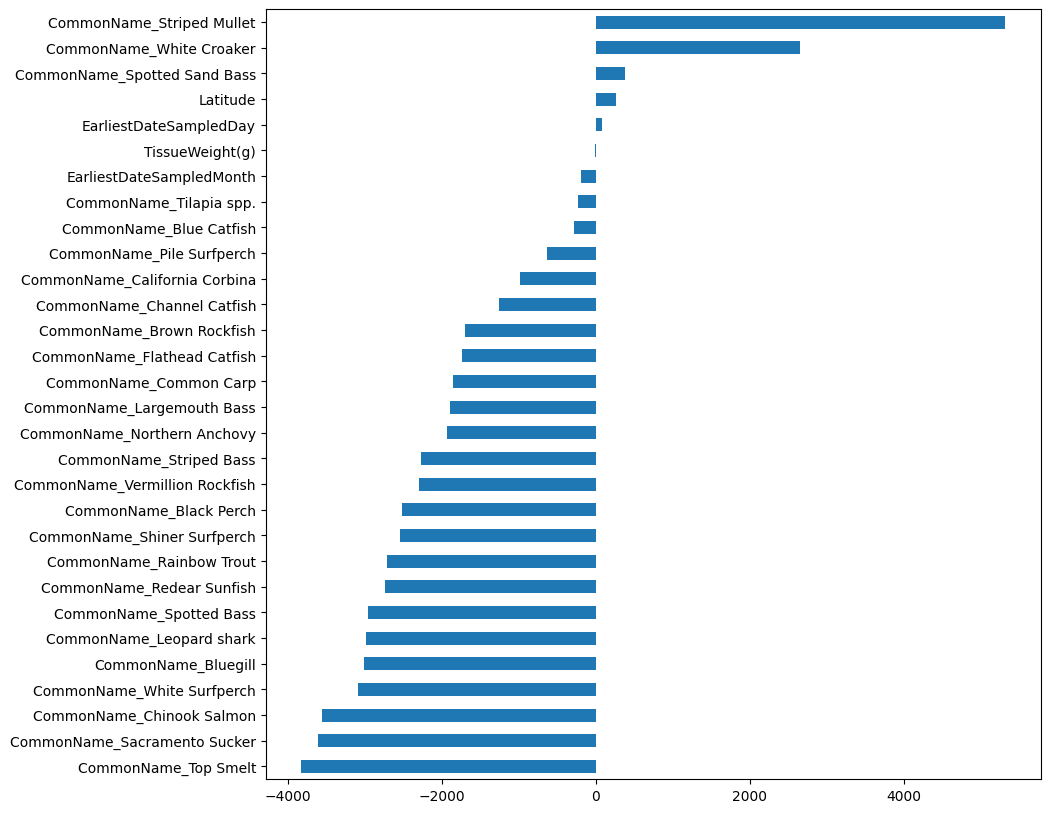

In [457]:
params_series = PCB_Lin_fitted2.params
p_values_series = PCB_Lin_fitted2.pvalues

significant_params = params_series[p_values_series < 0.05]
significant_params.drop('const', inplace=True)

plt.figure(figsize=(10, 10))
significant_params.sort_values().plot(kind='barh')

I graphed the residuals from both graphs, to determine if dropping the PCB_threshold column would make a difference, but behaved almost the same as the first model

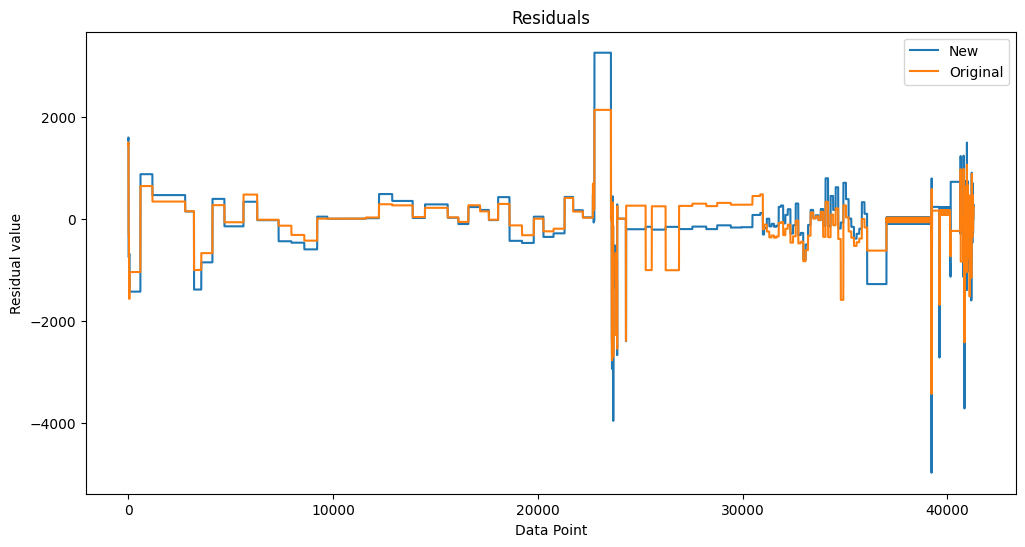

In [458]:
full_model_predictions = PCB_Lin_fitted.predict(X_withconstant)
full_model_residuals = y - full_model_predictions

new_model_predictions = PCB_Lin_fitted2.predict(X_withconstant2)
new_model_residuals = y - new_model_predictions

x_vals = list(range(y.shape[0])) # x-axis is index of each data point
plt.figure(figsize = (12,6))
plt.plot(x_vals,new_model_residuals,label="New")
plt.plot(x_vals,full_model_residuals,label="Original")
plt.xlabel("Data Point")
plt.ylabel("Residual value")
plt.legend()
plt.title("Residuals")
plt.show()

## More Linear Models Evaluation

### Looking at Residuals

Residuals needs to be normally distributed and follow a normal (bell curve) distribution to show that this is a good predictive model

Model 1

In [459]:
# We can also use our results object to get residuals
model_resids = PCB_Lin_fitted.resid
# Fitted values are the predicted Y for each input row of independent variables.
# These values are also in the results object
model_fittedvals = PCB_Lin_fitted.fittedvalues


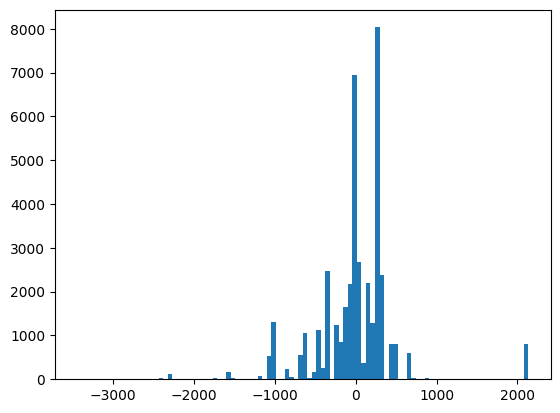

In [460]:
plt.figure()
plt.hist(model_resids, bins = 100)
plt.show()

The graph looks like it's left skewed... with a few outliners to the right


Model 2

In [461]:
# We can also use our results object to get residuals
model_resids2 = PCB_Lin_fitted2.resid
# Fitted values are the predicted Y for each input row of independent variables.
# These values are also in the results object
model_fittedvals2 = PCB_Lin_fitted2.fittedvalues

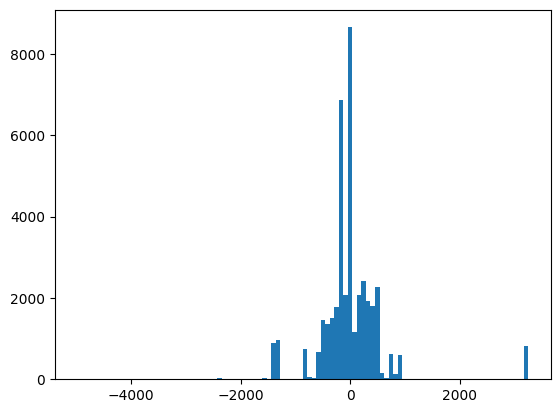

In [462]:
plt.figure()
plt.hist(model_resids2, bins = 100)
plt.show()

The graph looks like it's left skewed as well, but also tighter in the center... with a few more outliners to the right


### Shapiro-Wilk Test on Residuals Using Scipy

In [463]:
import scipy.stats as stats

#Model 1
tstat, pval = stats.shapiro(model_resids)
print("Shapiro-Wilk test on residuals: p-value = {:4.3f}".format(pval))

Shapiro-Wilk test on residuals: p-value = 0.000


In [464]:
#Model 2
tstat, pval = stats.shapiro(model_resids2)
print("Shapiro-Wilk test on residuals: p-value = {:4.3f}".format(pval))

Shapiro-Wilk test on residuals: p-value = 0.000


Both p-value are showing less than 0.05. We can throw out the P-value.

### Test on Homoscedasticity  

Residuals must have constant variance across all ranges of predicted values in order for the variance of error terms to be similar across the values of the independent variables.

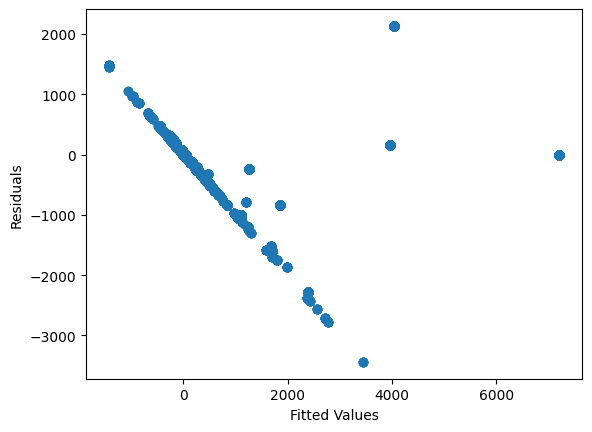

In [465]:
#Model 1

plt.figure()
plt.scatter(model_fittedvals, model_resids)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

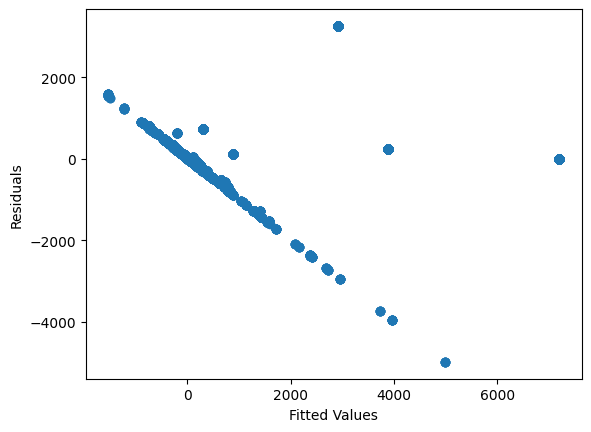

In [466]:
#Model 2

plt.figure()
plt.scatter(model_fittedvals2, model_resids2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The data is heteroscedastic, which means that the coefficients of our linear model are not well determined.

## Third Model - Logisic Regression

Next, I am going to try is a logistics regression looking at the PCB Threshold since it is binary and the data sets has a lot of categorical varibles.

In [467]:
X_log = PCB_df.drop('PCB_threshold', axis=1)
y_log = PCB_df['PCB_threshold'].copy()

In [468]:
y_log.value_counts()

PCB_threshold
0    37765
1     3513
Name: count, dtype: int64

### Detecting Collinearity

Same process using .corr

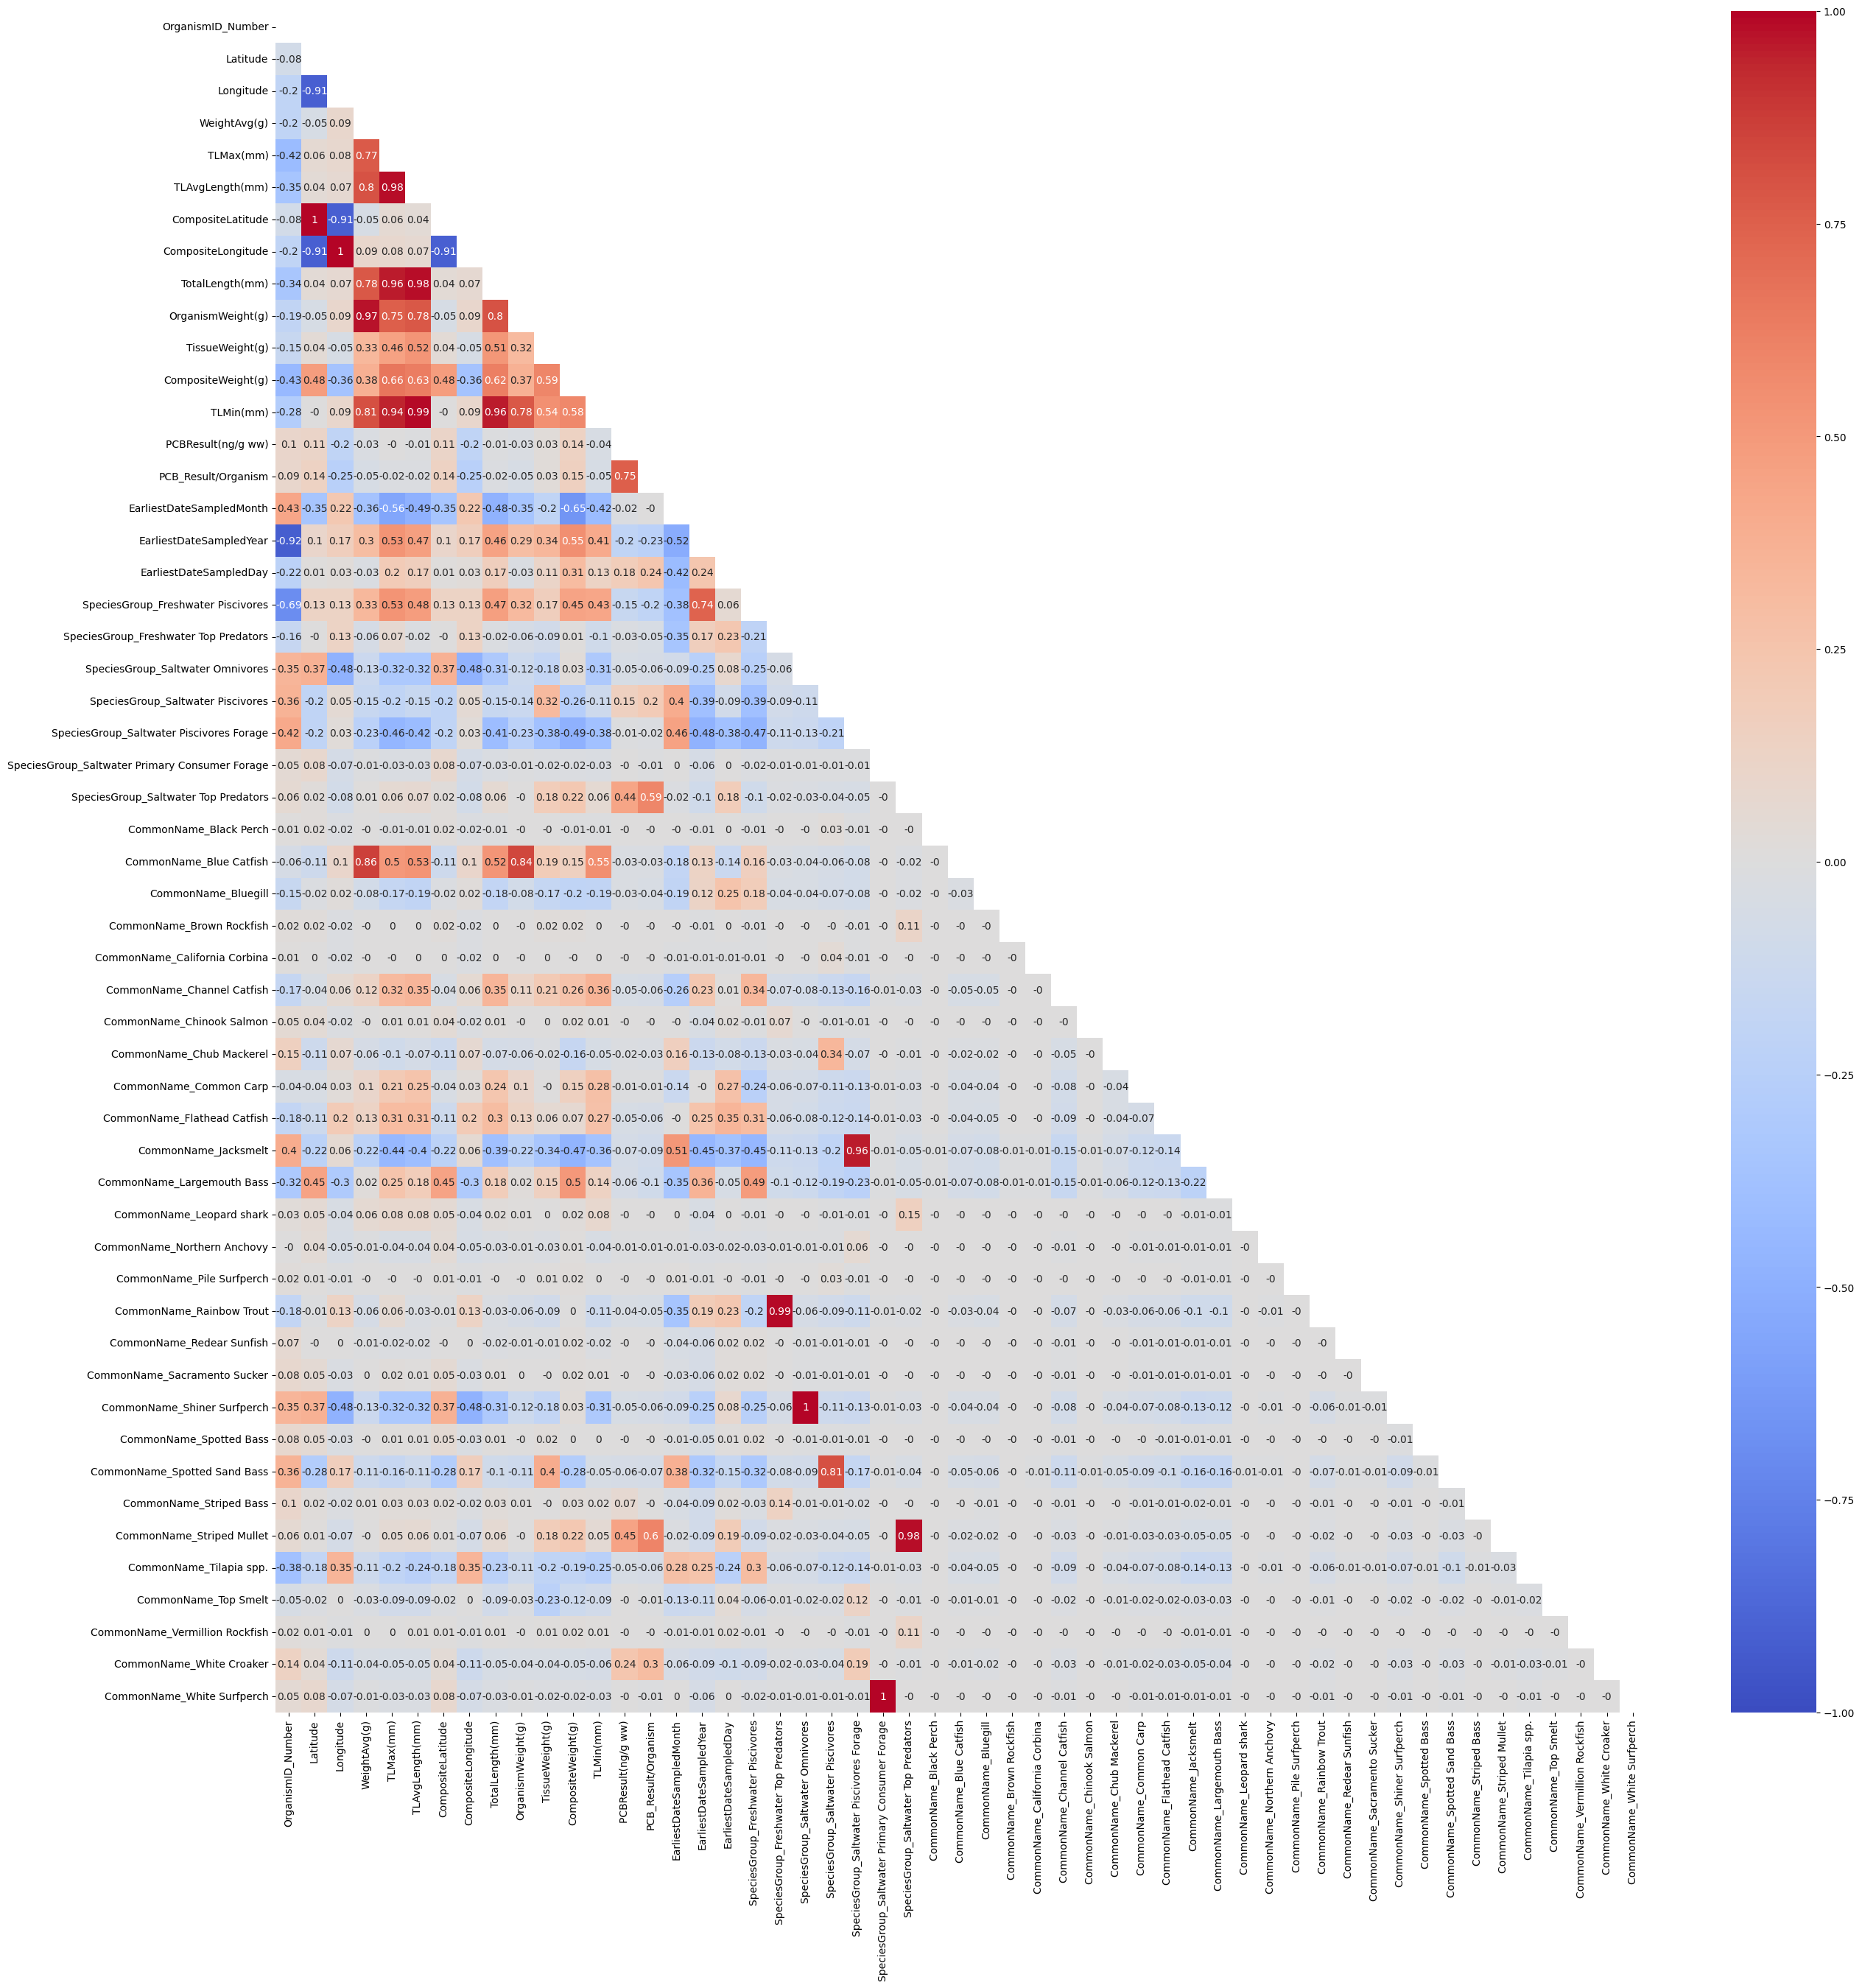

In [469]:
# Calculate all the correlations between each independent variable
corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

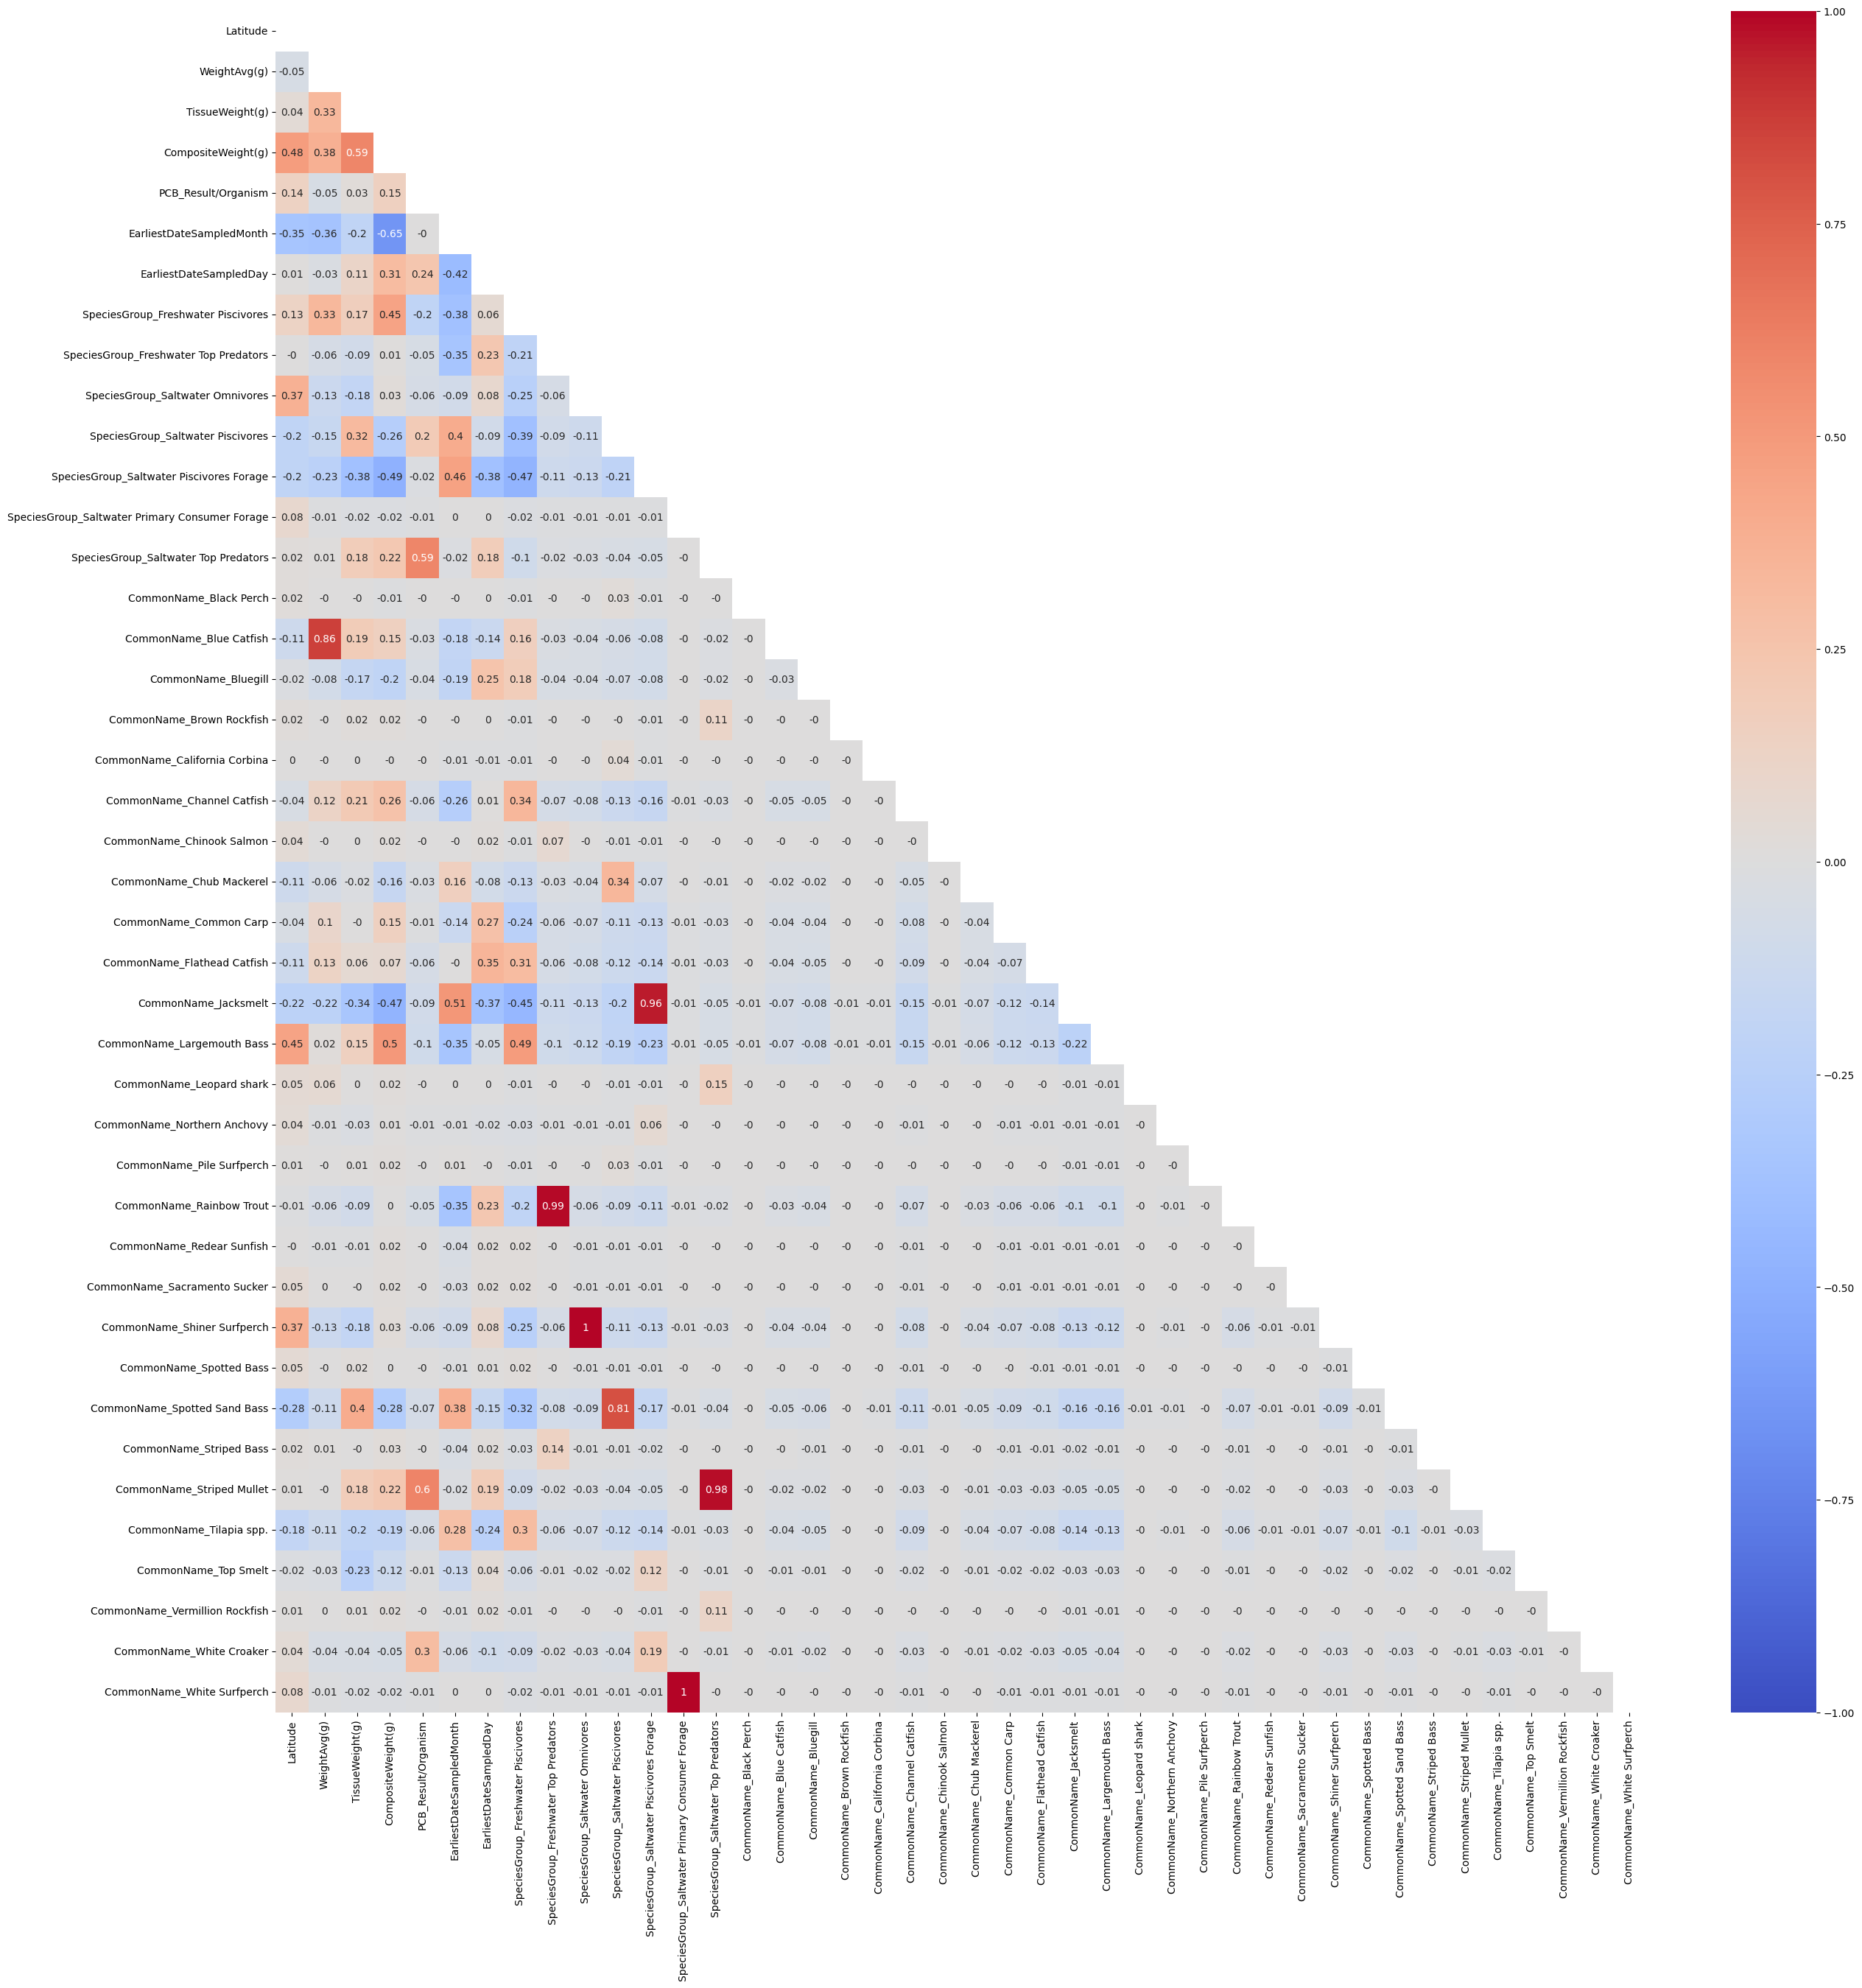

In [470]:
X_log_drop_col = ['Longitude', 'TLMax(mm)', 'TLAvgLength(mm)',
       'CompositeLatitude','CompositeLongitude','TotalLength(mm)',
       'OrganismWeight(g)',
       'TLMin(mm)', 'PCBResult(ng/g ww)',
       'OrganismID_Number', 'EarliestDateSampledYear'
       ]
X_log.drop(columns=X_log_drop_col, inplace=True)

corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

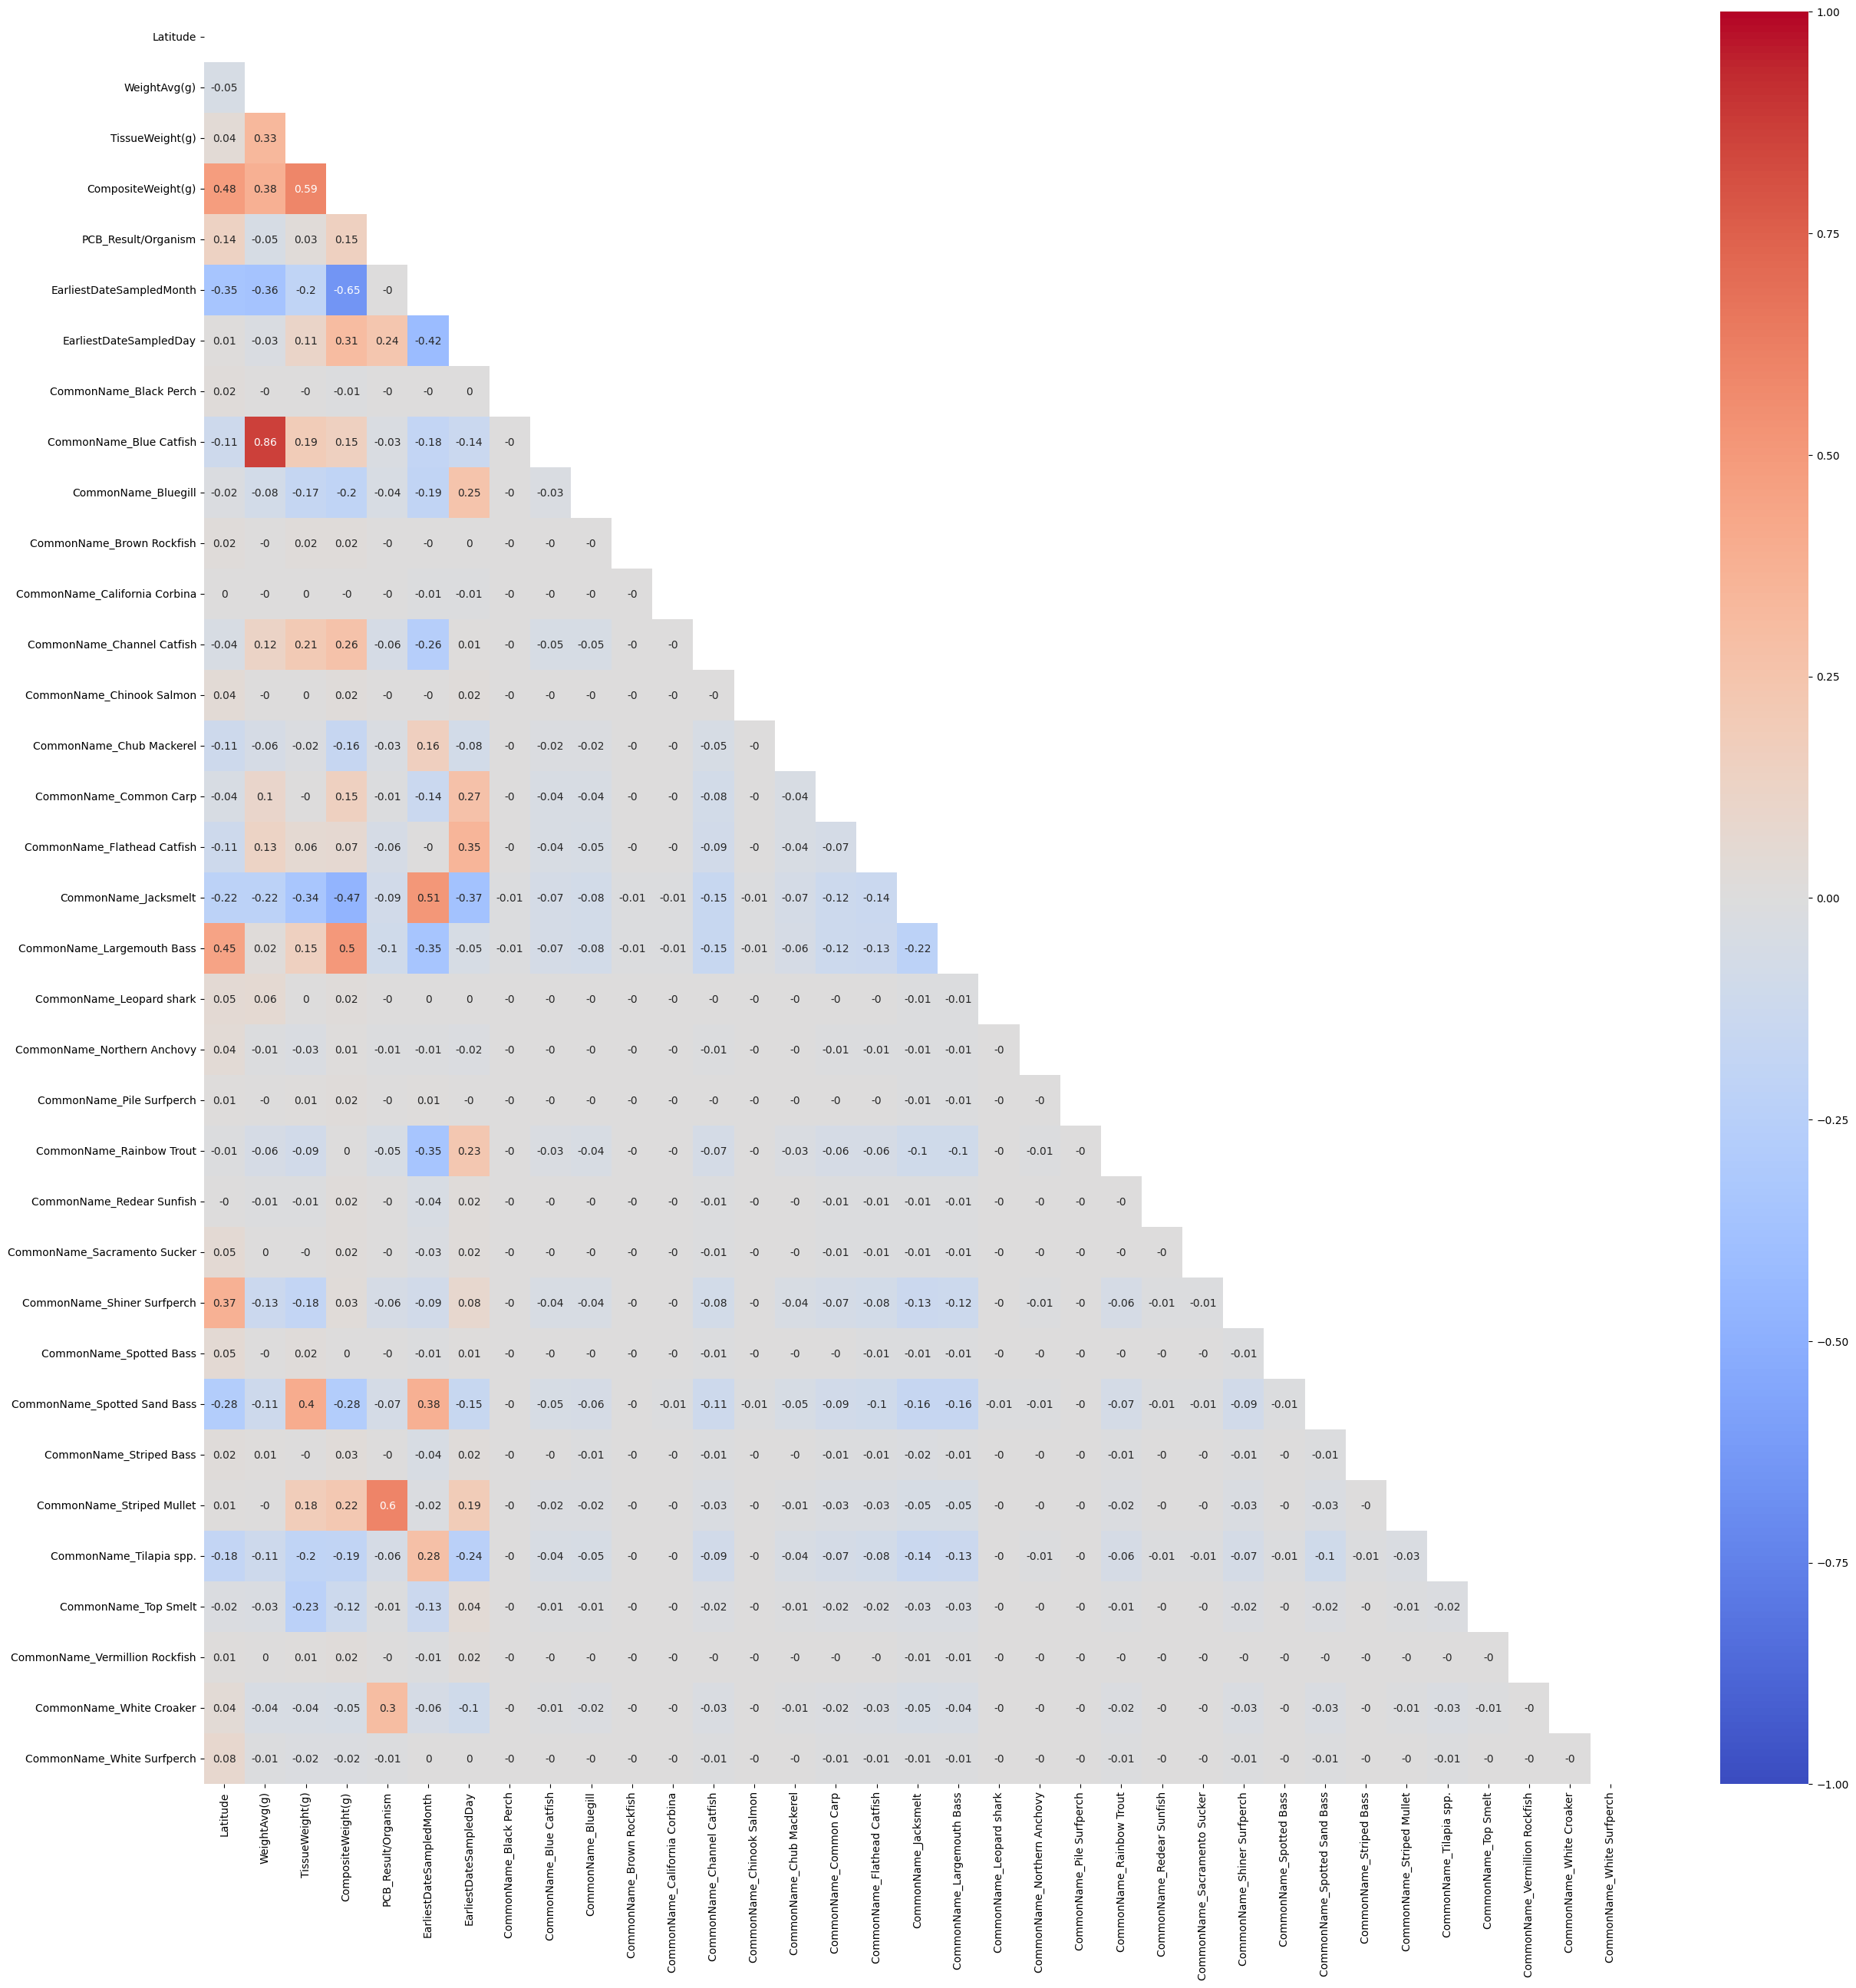

In [471]:

columns_with_speciesgroup = [col for col in X_log.columns if 'SpeciesGroup' in col]


X_log.drop(columns=columns_with_speciesgroup, inplace=True)

# Calculate all the correlations between each independent variable
corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

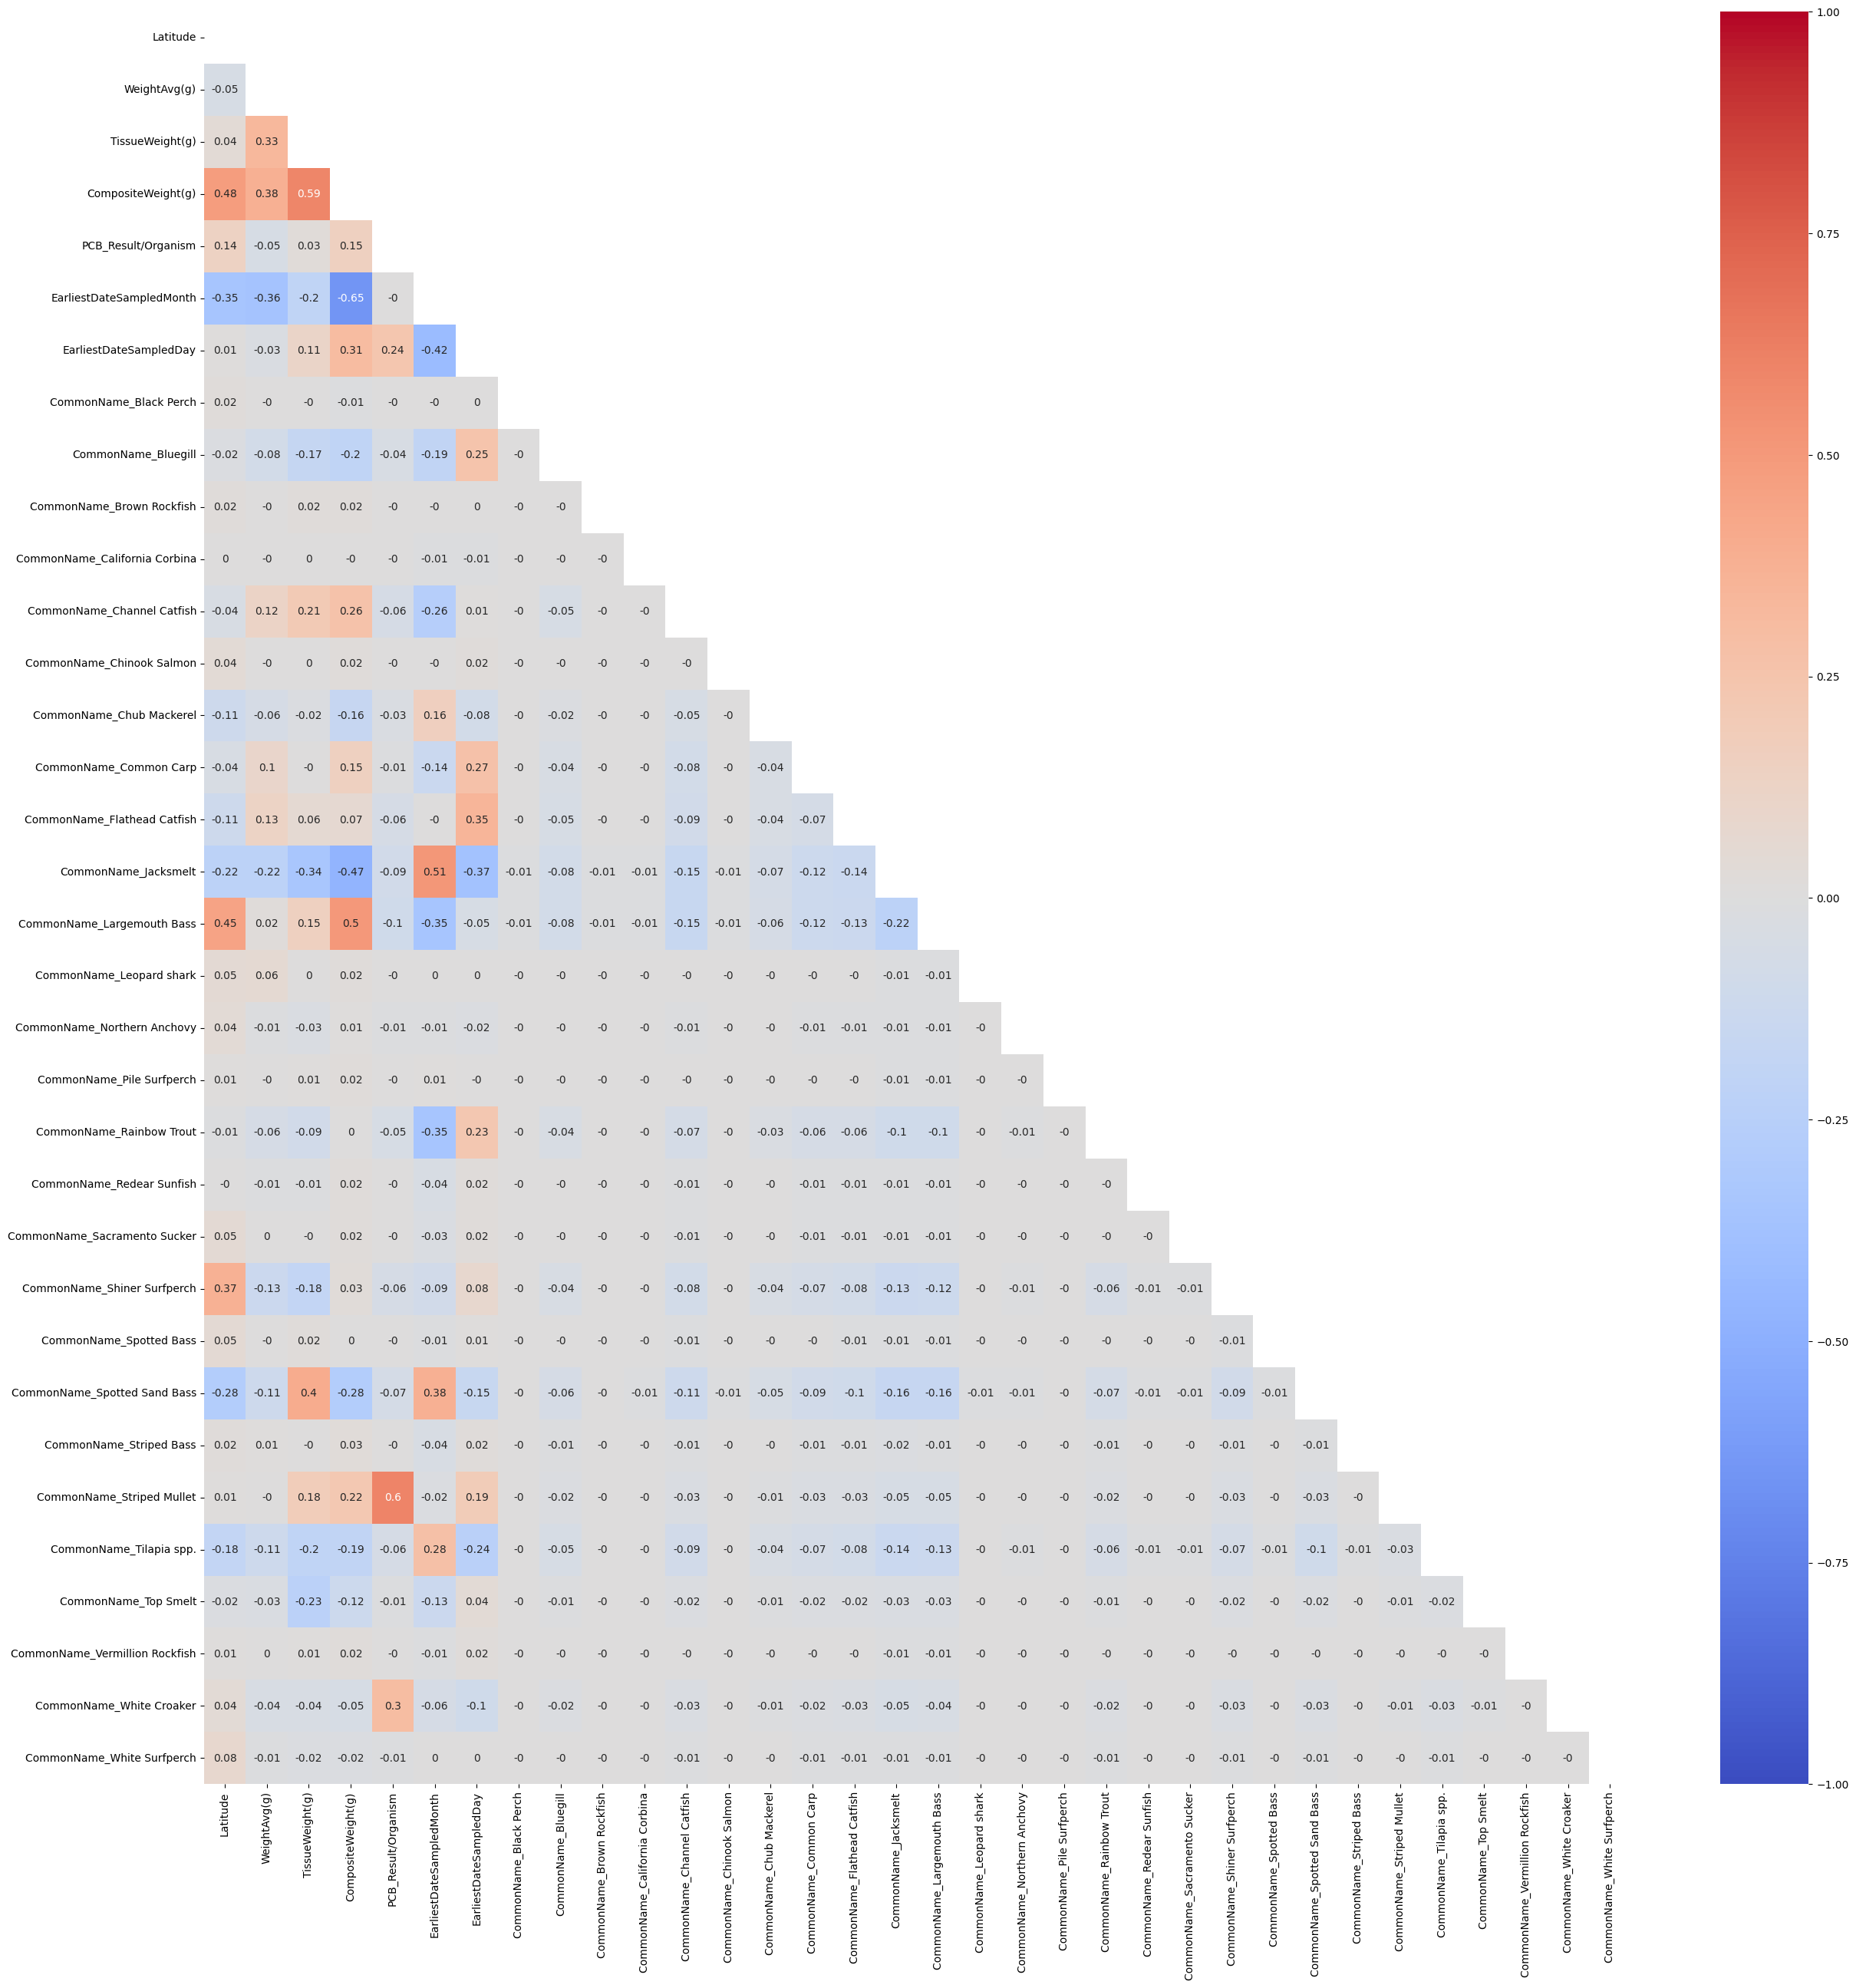

In [472]:
X_log.drop(columns=['CommonName_Blue Catfish'], inplace=True)
# Calculate all the correlations between each independent variable
corr_df = X_log.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize
plt.figure(figsize=(30,30))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

## Detecting Multicolinearity with VIF Values

In [473]:
X3 = X_log.copy()
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.919019
WeightAvg(g)                       3.619182
TissueWeight(g)                    6.412719
CompositeWeight(g)                11.327336
PCB_Result/Organism                6.310045
EarliestDateSampledMonth           7.801367
EarliestDateSampledDay             3.409520
CommonName_Black Perch             1.015782
CommonName_Bluegill                4.977918
CommonName_Brown Rockfish          1.012495
CommonName_California Corbina      1.022400
CommonName_Channel Catfish         8.103450
CommonName_Chinook Salmon          1.034894
CommonName_Chub Mackerel           3.523463
CommonName_Common Carp             5.872277
CommonName_Flathead Catfish        7.124410
CommonName_Jacksmelt              19.204503
CommonName_Largemouth Bass        15.576608
CommonName_Leopard shark           1.025301
CommonName_Northern Anchovy        1.106457
CommonName_Pile Surfperch          1.013407
CommonName_Rainbow Trout           6.813551
CommonName_Redear Sunfish          1.069556
CommonName_Sacramento Sucker       1.067851
CommonName_Shiner Surfperch        8.596888
CommonName_Spotted Bass            1.049665
CommonName_Spotted Sand Bass      14.752764
CommonName_Striped Bass            1.106764
CommonName_Striped Mullet          2.020831
CommonName_Tilapia spp.            8.988652
CommonName_Top Smelt               1.861120
CommonName_Vermillion Rockfish     1.011803
CommonName_White Croaker           1.558590
CommonName_White Surfperch         1.104372
dtype: float64

In [474]:
X3.drop(columns=['WeightAvg(g)'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.851628
TissueWeight(g)                    6.398317
CompositeWeight(g)                11.316477
PCB_Result/Organism                4.940828
EarliestDateSampledMonth           7.452063
EarliestDateSampledDay             3.204955
CommonName_Black Perch             1.009469
CommonName_Bluegill                3.523063
CommonName_Brown Rockfish          1.006564
CommonName_California Corbina      1.009235
CommonName_Channel Catfish         4.184362
CommonName_Chinook Salmon          1.026191
CommonName_Chub Mackerel           2.464189
CommonName_Common Carp             3.900304
CommonName_Flathead Catfish        4.922984
CommonName_Jacksmelt              10.922161
CommonName_Largemouth Bass         8.111375
CommonName_Leopard shark           1.025021
CommonName_Northern Anchovy        1.052708
CommonName_Pile Surfperch          1.007163
CommonName_Rainbow Trout           4.135927
CommonName_Redear Sunfish          1.035668
CommonName_Sacramento Sucker       1.047062
CommonName_Shiner Surfperch        5.241939
CommonName_Spotted Bass            1.033634
CommonName_Spotted Sand Bass       9.772049
CommonName_Striped Bass            1.060213
CommonName_Striped Mullet          2.018416
CommonName_Tilapia spp.            5.171144
CommonName_Top Smelt               1.630900
CommonName_Vermillion Rockfish     1.007168
CommonName_White Croaker           1.379406
CommonName_White Surfperch         1.074615
dtype: float64

In [475]:
X3.drop(columns=['CompositeWeight(g)'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                           2.694075
TissueWeight(g)                    3.122577
PCB_Result/Organism                4.929178
EarliestDateSampledMonth           7.328713
EarliestDateSampledDay             3.189046
CommonName_Black Perch             1.008345
CommonName_Bluegill                3.133931
CommonName_Brown Rockfish          1.006264
CommonName_California Corbina      1.008566
CommonName_Channel Catfish         4.178933
CommonName_Chinook Salmon          1.024792
CommonName_Chub Mackerel           2.173690
CommonName_Common Carp             3.883867
CommonName_Flathead Catfish        4.890228
CommonName_Jacksmelt              10.008216
CommonName_Largemouth Bass         7.856856
CommonName_Leopard shark           1.023074
CommonName_Northern Anchovy        1.052284
CommonName_Pile Surfperch          1.006711
CommonName_Rainbow Trout           4.094782
CommonName_Redear Sunfish          1.035203
CommonName_Sacramento Sucker       1.046821
CommonName_Shiner Surfperch        5.238018
CommonName_Spotted Bass            1.028228
CommonName_Spotted Sand Bass       7.234148
CommonName_Striped Bass            1.055952
CommonName_Striped Mullet          1.976421
CommonName_Tilapia spp.            5.037651
CommonName_Top Smelt               1.618837
CommonName_Vermillion Rockfish     1.006982
CommonName_White Croaker           1.307784
CommonName_White Surfperch         1.066001
dtype: float64

In [476]:
X3.drop(columns=['CommonName_Jacksmelt'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                          2.693995
TissueWeight(g)                   3.069550
PCB_Result/Organism               3.334518
EarliestDateSampledMonth          5.452808
EarliestDateSampledDay            3.171122
CommonName_Black Perch            1.004232
CommonName_Bluegill               2.529773
CommonName_Brown Rockfish         1.002763
CommonName_California Corbina     1.002397
CommonName_Channel Catfish        2.311446
CommonName_Chinook Salmon         1.016453
CommonName_Chub Mackerel          1.104230
CommonName_Common Carp            2.356027
CommonName_Flathead Catfish       2.282636
CommonName_Largemouth Bass        4.459441
CommonName_Leopard shark          1.013353
CommonName_Northern Anchovy       1.022964
CommonName_Pile Surfperch         1.001436
CommonName_Rainbow Trout          3.383785
CommonName_Redear Sunfish         1.028556
CommonName_Sacramento Sucker      1.036415
CommonName_Shiner Surfperch       3.216658
CommonName_Spotted Bass           1.019473
CommonName_Spotted Sand Bass      2.445869
CommonName_Striped Bass           1.037682
CommonName_Striped Mullet         1.925328
CommonName_Tilapia spp.           1.268015
CommonName_Top Smelt              1.565470
CommonName_Vermillion Rockfish    1.004001
CommonName_White Croaker          1.301017
CommonName_White Surfperch        1.038333
dtype: float64

In [477]:
X3.drop(columns=['EarliestDateSampledDay'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                          2.218020
TissueWeight(g)                   2.741419
PCB_Result/Organism               2.296443
EarliestDateSampledMonth          5.307161
CommonName_Black Perch            1.002584
CommonName_Bluegill               1.775272
CommonName_Brown Rockfish         1.002106
CommonName_California Corbina     1.002332
CommonName_Channel Catfish        2.093525
CommonName_Chinook Salmon         1.007565
CommonName_Chub Mackerel          1.103430
CommonName_Common Carp            1.630894
CommonName_Flathead Catfish       1.410784
CommonName_Largemouth Bass        3.669733
CommonName_Leopard shark          1.008766
CommonName_Northern Anchovy       1.019345
CommonName_Pile Surfperch         1.001369
CommonName_Rainbow Trout          2.518420
CommonName_Redear Sunfish         1.018825
CommonName_Sacramento Sucker      1.020683
CommonName_Shiner Surfperch       2.344409
CommonName_Spotted Bass           1.012058
CommonName_Spotted Sand Bass      2.396908
CommonName_Striped Bass           1.025944
CommonName_Striped Mullet         1.879984
CommonName_Tilapia spp.           1.266114
CommonName_Top Smelt              1.448343
CommonName_Vermillion Rockfish    1.001757
CommonName_White Croaker          1.234886
CommonName_White Surfperch        1.024923
dtype: float64

In [478]:
X3.drop(columns=['EarliestDateSampledMonth'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                          2.150488
TissueWeight(g)                   1.870787
PCB_Result/Organism               2.204506
CommonName_Black Perch            1.001573
CommonName_Bluegill               1.119964
CommonName_Brown Rockfish         1.001958
CommonName_California Corbina     1.001164
CommonName_Channel Catfish        1.490164
CommonName_Chinook Salmon         1.005807
CommonName_Chub Mackerel          1.079794
CommonName_Common Carp            1.219121
CommonName_Flathead Catfish       1.309662
CommonName_Largemouth Bass        2.183836
CommonName_Leopard shark          1.008016
CommonName_Northern Anchovy       1.010174
CommonName_Pile Surfperch         1.001225
CommonName_Rainbow Trout          1.175420
CommonName_Redear Sunfish         1.001919
CommonName_Sacramento Sucker      1.009087
CommonName_Shiner Surfperch       1.704959
CommonName_Spotted Bass           1.009406
CommonName_Spotted Sand Bass      1.858324
CommonName_Striped Bass           1.005308
CommonName_Striped Mullet         1.859234
CommonName_Tilapia spp.           1.259944
CommonName_Top Smelt              1.091571
CommonName_Vermillion Rockfish    1.001247
CommonName_White Croaker          1.177343
CommonName_White Surfperch        1.020344
dtype: float64

In [479]:
# I am dropping this even though the VIF is low since this is another target variable for the other model

X3.drop(columns=['PCB_Result/Organism'], inplace=True)
X_withconstant3 = sm.add_constant(X3)
variance_inflation_factor(X_withconstant3, 1)
pd.Series([variance_inflation_factor(X_withconstant3.values, i)
          for i in range(X_withconstant3.shape[1])],
         index=X_withconstant3.columns)[1:] # leaving out the constant
#threshold = 5

Latitude                          1.922475
TissueWeight(g)                   1.853821
CommonName_Black Perch            1.001257
CommonName_Bluegill               1.101124
CommonName_Brown Rockfish         1.001745
CommonName_California Corbina     1.000984
CommonName_Channel Catfish        1.460201
CommonName_Chinook Salmon         1.004791
CommonName_Chub Mackerel          1.076685
CommonName_Common Carp            1.207112
CommonName_Flathead Catfish       1.286703
CommonName_Largemouth Bass        1.975656
CommonName_Leopard shark          1.006685
CommonName_Northern Anchovy       1.008094
CommonName_Pile Surfperch         1.001133
CommonName_Rainbow Trout          1.146250
CommonName_Redear Sunfish         1.001642
CommonName_Sacramento Sucker      1.007395
CommonName_Shiner Surfperch       1.560654
CommonName_Spotted Bass           1.008090
CommonName_Spotted Sand Bass      1.854389
CommonName_Striped Bass           1.004514
CommonName_Striped Mullet         1.122411
CommonName_Tilapia spp.           1.237641
CommonName_Top Smelt              1.087337
CommonName_Vermillion Rockfish    1.001151
CommonName_White Croaker          1.039555
CommonName_White Surfperch        1.016750
dtype: float64

### Fitting The Logistic Model

Model 1

In [494]:
#fitting the model with backward selection

# 0. ADD THAT CONSTANT
X_const3 = sm.add_constant(X3)


# 1. Instatiate the model
PCB_log= sm.Logit(y_log, X_const3)

# Fit the model with L1 regularization
PCB_log_fitted = PCB_log.fit_regularized(method='l1', alpha= 0.1)
# Adjust alpha for stronger/weaker regularization


# Look at the results
PCB_log_fitted.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13378832649097952
            Iterations: 362
            Function evaluations: 370
            Gradient evaluations: 362


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          PCB_threshold   No. Observations:                41278
Model:                          Logit   Df Residuals:                    41256
Method:                           MLE   Df Model:                           21
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                  0.5415
Time:                        04:42:42   Log-Likelihood:                -5509.0
converged:                       True   LL-Null:                       -12015.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -16.5838      0.464    -35.716      0.000     -17.494     -15.674
Latitude                         0.4719      0.014     33.904      0.000       0.445       0.499
TissueWeight(g)                 -0.0560      0.002    -34.732      0.000      -0.059      -0.053
CommonName_Bluegill            -10.3023      4.750     -2.169      0.030     -19.611      -0.993
CommonName_Channel Catfish      -2.6359      0.215    -12.240      0.000      -3.058      -2.214
CommonName_Chinook Salmon       -4.5618      2.978     -1.532      0.126     -10.399       1.275
CommonName_Chub Mackerel        -6.2915      2.945     -2.136      0.033     -12.064      -0.519
CommonName_Common Carp          -0.7634      0.177     -4.301      0.000      -1.111      -0.416
CommonName_Flathead Catfish     -7.4228      2.878     -2.579      0.010     -13.063      -1.782
CommonName_Largemouth Bass      -4.3010      0.198    -21.729      0.000      -4.689      -3.913
CommonName_Leopard shark        -5.1858      3.182     -1.630      0.103     -11.423       1.051
CommonName_Northern Anchovy     -7.3684      5.037     -1.463      0.144     -17.241       2.504
CommonName_Rainbow Trout        -8.6820      3.913     -2.219      0.027     -16.352      -1.012
CommonName_Sacramento Sucker    -5.3442      3.075     -1.738      0.082     -11.371       0.683
CommonName_Shiner Surfperch    -11.1592      4.427     -2.521      0.012     -19.837      -2.482
CommonName_Spotted Sand Bass     0.9068      0.119      7.628      0.000       0.674       1.140
CommonName_Striped Bass          2.6533      0.359      7.396      0.000       1.950       3.356
CommonName_Striped Mullet       12.8632      2.147      5.991      0.000       8.655      17.072
CommonName_Tilapia spp.         -8.4222      2.582     -3.262      0.001     -13.483      -3.361
CommonName_Top Smelt            -5.6459      0.264    -21.369      0.000      -6.164      -5.128
CommonName_White Croaker         4.0278      0.231     17.410      0.000       3.574       4.481
CommonName_White Surfperch      -8.2352      4.112     -2.003      0.045     -16.294      -0.177
================================================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [481]:
# Calculate soft predictions
y_proba = PCB_log_fitted.predict(X_const3)

# Convert soft predictions to hard predictions 0/1
y_pred = np.where(y_proba >= 0.5, 1, 0)

# Calculate # correct
num_correct = (y_pred == y_log).sum()

# Calculate the percentage accuracy
pct_accuracy = num_correct/X.shape[0]

print(f'The baseline model accuracy is {np.round(pct_accuracy*100.0, 3)}%')

The baseline model accuracy is 94.704%


In [483]:
#Since these columns has a p-value over 0.05, I have to drop them and then see how that'd affect my model accuracy
X3.drop(columns=['CommonName_Brown Rockfish', 'CommonName_Black Perch', 'CommonName_California Corbina', 'CommonName_Pile Surfperch', 'CommonName_Spotted Bass', 'CommonName_Redear Sunfish','CommonName_Vermillion Rockfish'], inplace=True)


KeyError: "['CommonName_Brown Rockfish', 'CommonName_Black Perch', 'CommonName_California Corbina', 'CommonName_Pile Surfperch', 'CommonName_Spotted Bass', 'CommonName_Redear Sunfish', 'CommonName_Vermillion Rockfish'] not found in axis"

In [484]:
X4 = X3.copy()
# 0. ADD THAT CONSTANT
X_const4 = sm.add_constant(X4)

# 1. Instatiate the model
PCB_log2= sm.Logit(y_log, X_const4)

# Fit the model with L1 regularization
PCB_log_fitted2 = PCB_log2.fit_regularized(method='l1', alpha= 0.5)  # Adjust alpha as needed
# Adjust alpha for stronger/weaker regularization


# Look at the results
PCB_log_fitted2.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1349416296125823
            Iterations: 340
            Function evaluations: 347
            Gradient evaluations: 340


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          PCB_threshold   No. Observations:                41278
Model:                          Logit   Df Residuals:                    41256
Method:                           MLE   Df Model:                           21
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                  0.5411
Time:                        04:39:59   Log-Likelihood:                -5513.9
converged:                       True   LL-Null:                       -12015.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -16.3728      0.462    -35.456      0.000     -17.278     -15.468
Latitude                         0.4654      0.014     33.642      0.000       0.438       0.493
TissueWeight(g)                 -0.0554      0.002    -35.029      0.000      -0.058      -0.052
CommonName_Bluegill             -7.8006      1.407     -5.543      0.000     -10.559      -5.043
CommonName_Channel Catfish      -2.5864      0.211    -12.240      0.000      -3.001      -2.172
CommonName_Chinook Salmon       -3.0239      1.455     -2.078      0.038      -5.876      -0.172
CommonName_Chub Mackerel        -4.8548      1.429     -3.398      0.001      -7.655      -2.055
CommonName_Common Carp          -0.7329      0.174     -4.216      0.000      -1.074      -0.392
CommonName_Flathead Catfish     -6.0399      1.433     -4.214      0.000      -8.849      -3.230
CommonName_Largemouth Bass      -4.2651      0.196    -21.777      0.000      -4.649      -3.881
CommonName_Leopard shark        -3.5141      1.461     -2.405      0.016      -6.378      -0.650
CommonName_Northern Anchovy     -4.8158      1.443     -3.337      0.001      -7.644      -1.987
CommonName_Rainbow Trout        -6.6152      1.392     -4.751      0.000      -9.344      -3.886
CommonName_Sacramento Sucker    -3.7823      1.454     -2.602      0.009      -6.632      -0.933
CommonName_Shiner Surfperch     -8.9748      1.504     -5.966      0.000     -11.923      -6.026
CommonName_Spotted Sand Bass     0.8747      0.118      7.394      0.000       0.643       1.107
CommonName_Striped Bass          2.5920      0.354      7.320      0.000       1.898       3.286
CommonName_Striped Mullet       12.0816      1.486      8.131      0.000       9.170      14.994
CommonName_Tilapia spp.         -7.3363      1.500     -4.890      0.000     -10.277      -4.396
CommonName_Top Smelt            -5.5703      0.262    -21.287      0.000      -6.083      -5.057
CommonName_White Croaker         4.0049      0.229     17.525      0.000       3.557       4.453
CommonName_White Surfperch      -6.1560      1.518     -4.055      0.000      -9.132      -3.180
================================================================================================
"""

Model 2

In [487]:
# Calculate soft predictions
y_proba = PCB_log_fitted2.predict(X_const4)

# Convert soft predictions to hard predictions 0/1
y_pred = np.where(y_proba >= 0.5, 1, 0)

# Calculate # correct
num_correct = (y_pred == y_log).sum()

# Calculate the percentage accuracy
pct_accuracy = num_correct/X.shape[0]

print(f'The baseline model accuracy is {np.round(pct_accuracy*100.0, 3)}%')

The baseline model accuracy is 94.728%


The performance of the model slightly improved.

## Looking at Coeficients


<Axes: >

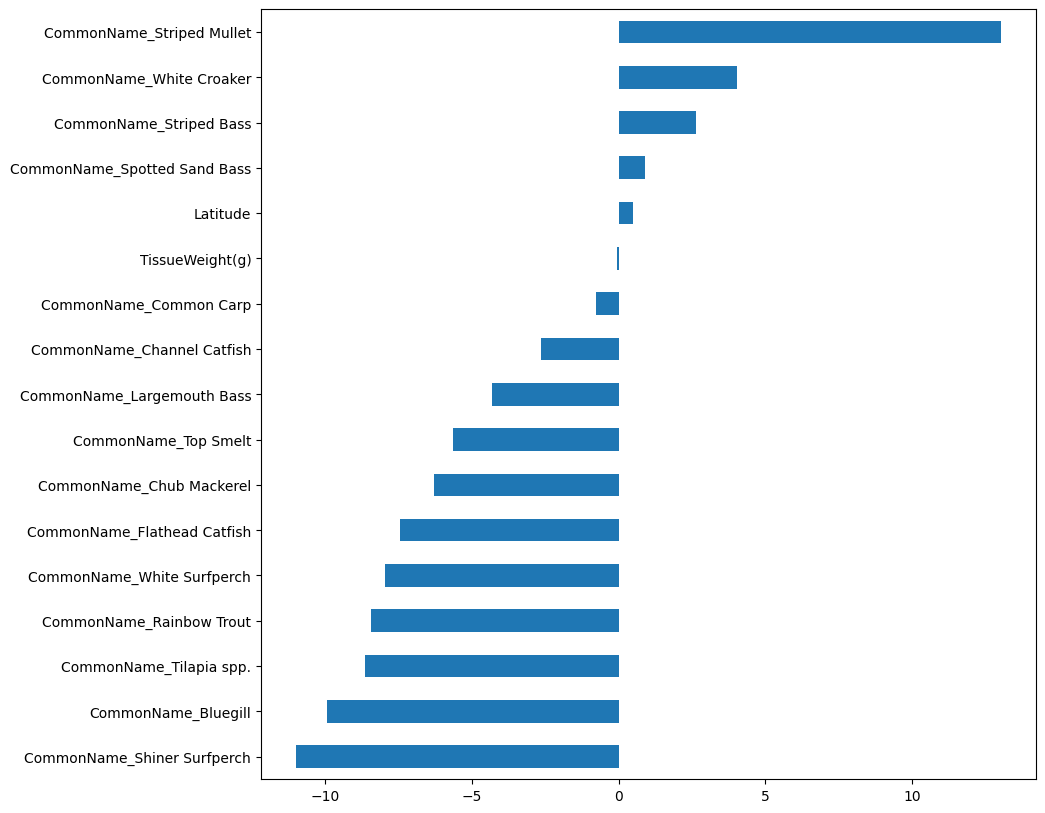

In [488]:
params_series = PCB_log_fitted.params
p_values_series = PCB_log_fitted.pvalues

significant_params = params_series[p_values_series < 0.05]
significant_params.drop('const', inplace=True)

plt.figure(figsize=(10, 10))
significant_params.sort_values().plot(kind='barh')

Mullet still shows the highest positive correlation

In [489]:
PCB_log_fitted.pvalues.sort_values()

const                             1.437876e-281
TissueWeight(g)                   1.152528e-263
Latitude                          3.551476e-254
CommonName_Largemouth Bass        1.368808e-105
CommonName_Top Smelt              5.262187e-101
CommonName_White Croaker           1.259645e-67
CommonName_Channel Catfish         9.510604e-35
CommonName_Spotted Sand Bass       4.285198e-14
CommonName_Striped Bass            1.932319e-13
CommonName_Striped Mullet          2.402558e-08
CommonName_Common Carp             1.435226e-05
CommonName_Tilapia spp.            2.559697e-03
CommonName_Shiner Surfperch        6.305990e-03
CommonName_Flathead Catfish        1.032740e-02
CommonName_Bluegill                1.211221e-02
CommonName_Rainbow Trout           1.360822e-02
CommonName_White Surfperch         2.411319e-02
CommonName_Chub Mackerel           3.091983e-02
CommonName_Sacramento Sucker       8.415827e-02
CommonName_Northern Anchovy        8.800942e-02
CommonName_Leopard shark           1.118052e-01
CommonName_Chinook Salmon          1.369090e-01
CommonName_Black Perch             2.132075e-01
CommonName_Redear Sunfish          3.045645e-01
CommonName_Spotted Bass            3.097088e-01
CommonName_California Corbina      3.870429e-01
CommonName_Brown Rockfish          8.556838e-01
CommonName_Pile Surfperch          9.100486e-01
CommonName_Vermillion Rockfish     1.000000e+00
dtype: float64

Tissue Weight and Latitude has the highest P-values, meaning they are more likely to be randomly related to the y-value

In [490]:
coefficients_df = pd.DataFrame({'coeff': PCB_log_fitted.params,
                               'p_values': PCB_log_fitted.pvalues})

coefficients_df.reset_index(inplace=True)

coefficients_df.rename({'index': 'variable'}, axis='columns', inplace=True)
coefficients_df.head()

variable      coeff       p_values
0                   const -16.639566  1.437876e-281
1                Latitude   0.473601  3.551476e-254
2         TissueWeight(g)  -0.055778  1.152528e-263
3  CommonName_Black Perch  -3.833770   2.132075e-01
4     CommonName_Bluegill  -9.929851   1.211221e-02

Another visual to see how each of these independent variables shows an odd of either increasing or decreasing


In [491]:
categories = [] # Hold labels for bar
size = [] # Hold bar heights
colors = [] # Hold bar colors
p_values = [] # Used for additional text within the plot

p_value_color_scale = 1.5

# iterate through
for index, row in coefficients_df.iterrows():
    variable_name = row['variable'].strip()

    if (variable_name != 'const'): # We don't care much for the constant since we can modify it
        categories.append(variable_name)
        coefficients_value = row['coeff']

        p_value = round(row['p_values'], 2)
        p_values.append(p_value)

        color = [1.0, 1.0, 1.0]

        color[1] = (min(p_value_color_scale*p_value, 1.0)/1.0) # Make GREEN brighters
        if (coefficients_value >= 0):
            color[0] = color[1]
            column_size = np.exp(coefficients_value)
        else:
            color[2] = color[1]
            column_size = -1/np.exp(coefficients_value)

        column_size = round(column_size, 2)
        size.append(column_size)
        colors.append(color)

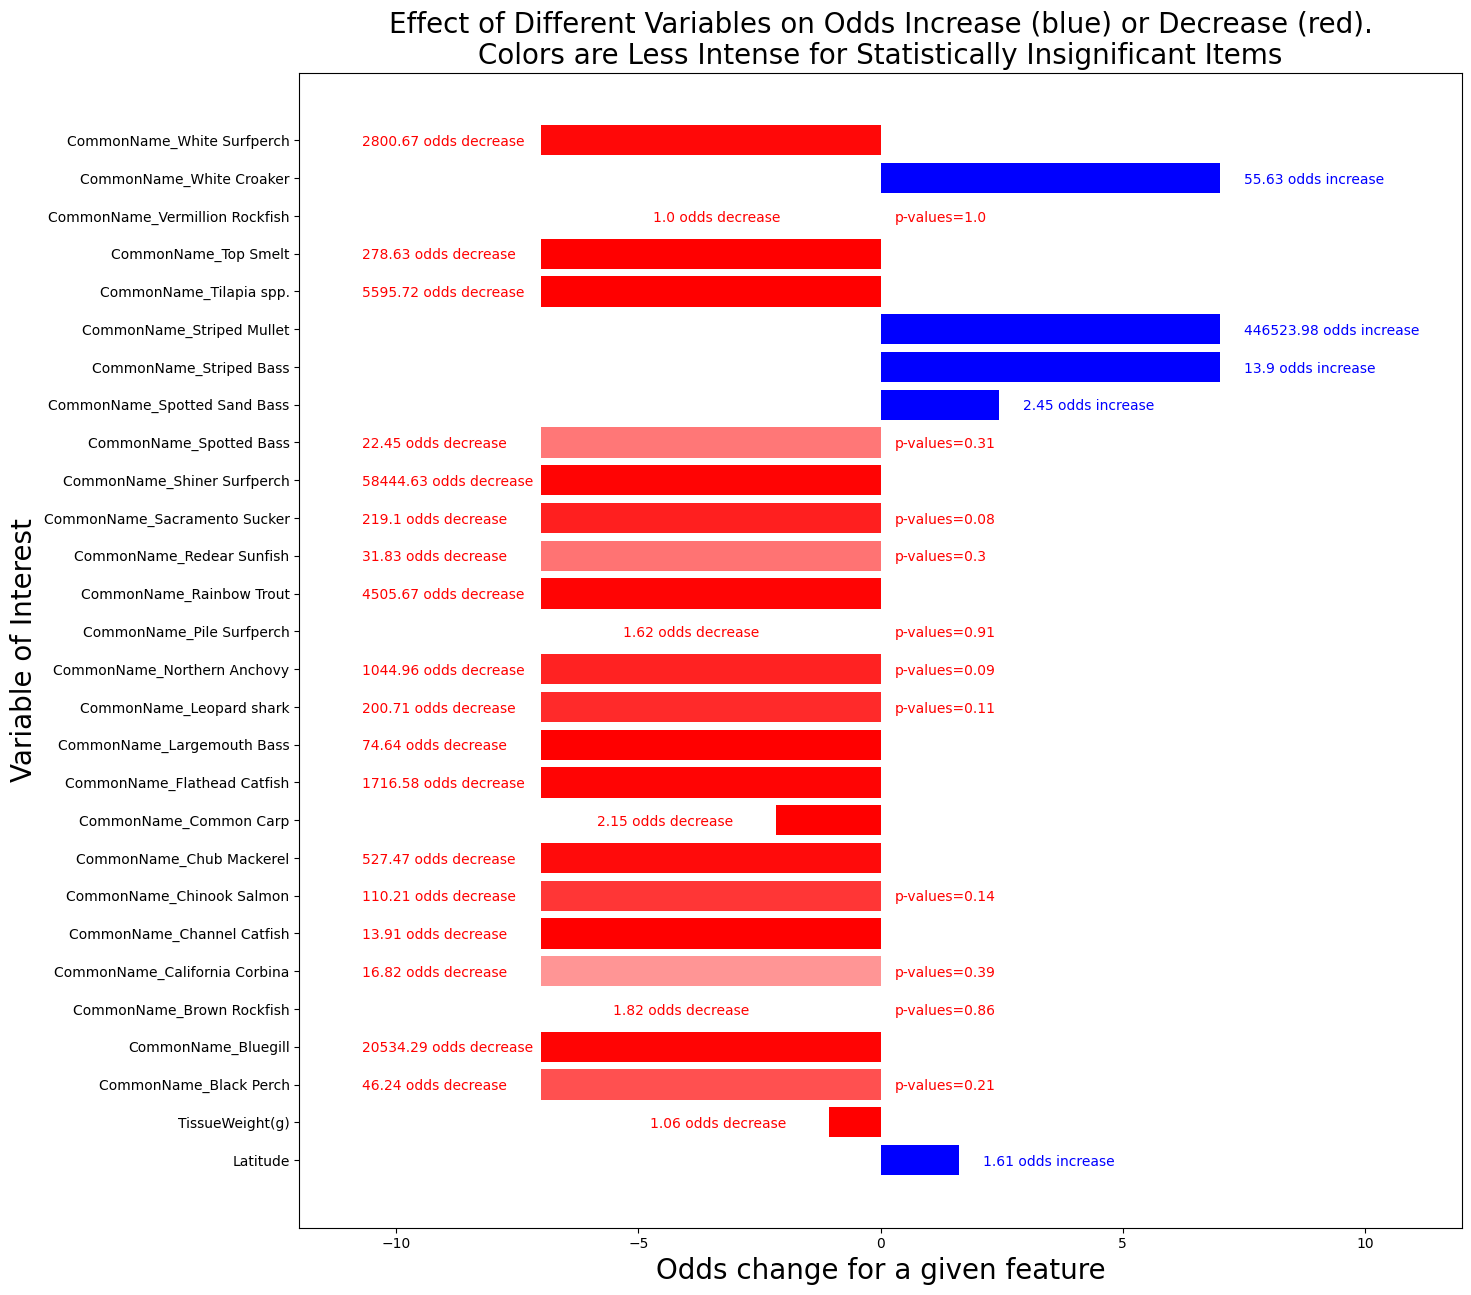

In [493]:


fix, ax = plt.subplots(figsize=(15, 15))

# Clip the bar sizes to a reasonable range
max_bar_size = 7  # Adjust this value as needed
size_clipped = np.clip(size, -max_bar_size, max_bar_size)

ax.barh(categories, size_clipped, color=colors)

for index, bar_size in enumerate(size):
    if (bar_size > 0.0):
        # Add a label text, using clipped size for placement
        ax.text(size_clipped[index] + 0.5, index - 0.15, f'{bar_size} odds increase', color='blue')

        # Add a p-value disclaimer
        if (p_values[index] > 0.05):
            ax.text(-2.5, index - 0.15, f'p-values={p_values[index]}', color='blue')
    else:
        # Label text, using clipped size for placement
        ax.text(size_clipped[index] - 3.7, index - 0.15, f'{abs(bar_size)} odds decrease', color='red')

        # p-value disclaimer
        if (p_values[index] >= 0.05):
            ax.text(0.3, index - 0.15, f'p-values={p_values[index]}', color='red')

# change the limit to make sure labels go inside the plot area
plt.xlim(-max_bar_size -5, max_bar_size + 5)  # Adjusted based on max_bar_size
plt.title('Effect of Different Variables on Odds Increase (blue) or Decrease (red).\
\nColors are Less Intense for Statistically Insignificant Items', size=20)
plt.xlabel('Odds change for a given feature', size=20)
plt.ylabel('Variable of Interest', size=20)
plt.show()

## Model Evaluations

For this sprint, I ran out of time to do a train-test split and look at the prediction & recall scores, as well as ROC & AUC values to check if my model is over-fitted. This will be part of my sprint 3 efforts, as well as testing with a Decision Tree and Random Forest models.
